In [1]:
import numpy as np
from matplotlib import rcParams
# Increase the default DPI, and change the file type from png to pdf 
rcParams['savefig.dpi']           = 300
#rcParams['savefig.extension']     = "pdf"

# Simplify paths by removing "invisible" points, useful for reducing
# file size when plotting a large number of points
rcParams['path.simplify']         = True

# Instead of individually increasing font sizes, point sizes, and line 
# thicknesses, I found it easier to just decrease the figure size so
# that the line weights of various components still agree 
rcParams['figure.figsize']        = 4,4

# In this example I am *not* setting "text.usetex : True", therefore the     
# following ensures that the fonts in math mode agree with the regular ones.  
# 
rcParams['font.family']           = "serif"
rcParams['mathtext.fontset']      = "custom"

# Increase the tick-mark lengths (defaults are 4 and 2)
rcParams['xtick.major.size']      = 6
rcParams['ytick.major.size']      = 6 
rcParams['xtick.minor.size']      = 3   
rcParams['ytick.minor.size']      = 3

rcParams['xtick.direction']      = "in"
rcParams['ytick.direction']      = "in" 
rcParams['xtick.top']      = True
rcParams['ytick.right']      = True 

# Increase the tick-mark widths as well as the widths of lines 
# used to draw marker edges to be consistent with the other figure
# linewidths (defaults are all 0.5)
rcParams['xtick.major.width']     = 1
rcParams['ytick.major.width']     = 1
rcParams['xtick.minor.width']     = 1
rcParams['ytick.minor.width']     = 1
rcParams['lines.markeredgewidth'] = 1

# Have the legend only plot one point instead of two, turn off the 
# frame, and reduce the space between the point and the label  
rcParams['legend.numpoints']      = 1
rcParams['legend.frameon']        = False
rcParams['legend.handletextpad']      = 0.3
import matplotlib.pyplot as plt
import math
import itertools
#import multiprocess as mp
from scipy.optimize import minimize
from scipy.optimize import lsq_linear
import pandas as pd
import os
import contextlib
import io
import sys
from scipy import stats
import json
import pandas as pd
from scipy.signal import detrend

from numpy import pi, cos 
from pymultinest.solve import solve
from pymultinest.run import run
from pymultinest import Analyzer
import pymultinest
import corner
import osqp
import scipy as sp
from scipy import sparse

import MulensModel as mu
from MulensModel.model import Model

%matplotlib inline

In [88]:
##############################
def magpat(q=0.01,d=1.0,theta=0.0,kappa=0.0,gamma=0.0,gammai=0.0,rmax=1.5,bmax=4.0,nrays=8e2):
        dx=d*np.cos(theta)
        dy=d*np.sin(theta)
        m1 = 1 / (1+q)
        m2 = q / (1 + q)
        nframes=17 # Choose an odd number; else you get divisions by zero nastiness
        npix=1000
        bframe = 2.0*float(bmax)/float(nframes)
        mag = np.zeros((npix,npix),dtype=np.float32)
        for i_frame in range(nframes):
                for j_frame in range(nframes):
                        dlx = 2.0*float(bmax)/float(nrays)/float(nframes)
                        dly = dlx
                        lx=np.linspace(-bmax+i_frame*bframe,-bmax+i_frame*bframe+bframe+dlx,nrays)
                        ly=np.linspace(-bmax+j_frame*bframe,-bmax+j_frame*bframe+bframe+dly,nrays)

                        [LX,LY]=np.meshgrid(ly,lx) # X varies on outer dimension; y on inner dimensio
                        L2 = LX**2.0+LY**2.0
                        L2q = (LX-dx)**2.0 + (LY-dy)**2.0
                        hit_x = LX- m1*LX/L2 - m2*(LX-dx)/L2q - (kappa+gamma)*LX - gammai*LY
                        hit_y = LY- m1*LY/L2 - m2*(LY-dy)/L2q - (kappa-gamma)*LY - gammai*LX
        #hit_x = L2*LX - (kappa+gamma)*LX
        #hit_y = L2*LY - (kappa-gamma)*LY

                        tp,x,y = np.histogram2d(hit_y.flatten(),hit_x.flatten(),bins=[npix,npix],range=[[-rmax,rmax],[-rmax,rmax]])
                        mag+=tp

#                         print ("\n -------------------------- \n")
#                         print ("FRAME", i_frame, j_frame)
#                         print ("XRANGE", -bmax+i_frame*bframe,-bmax+i_frame*bframe+bframe+dlx)
#                         print ("YRANGE", -bmax+j_frame*bframe,-bmax+j_frame*bframe+bframe+dly)
#                         print ("HIT RANGE", np.amin(hit_x),np.amax(hit_x), np.amin(hit_y), np.amax(hit_y))

        ext=[np.amin(x),np.amax(x),np.amin(y),np.amax(y)]
#       print "fraction of captured rays"
#        print np.sum(mag)/nrays/nrays
#       print " --------------------------------- "
        x=0.5*(x[1:]+x[:-1])
        y=0.5*(y[1:]+y[:-1])
        dx=x[2]-x[1]
        dy=y[2]-y[1]

        mag/=((2*rmax/float(npix))/(2*bmax/nrays/float(nframes)))**2.0
        #plt.imshow(mag,interpolation='none',extent=ext,cmap='gray',vmin=1.0,vmax=20.0); plt.colorbar()
        #plt.show()
        #plt.close()
        #hdr = pf.Header([('SIMPLE',True),('BITPIX',-32),('NAXIS',2),('NAXIS1',npix),('NAXIS2',npix),('CRVAL1',x[0]),('CDELT1',dx),('CRPIX1',0),('CRVAL2',y[0]),('CDELT2',dy),('CRPIX2',0), ('CUNIT1','TH_E'), ('CUNIT2','TH_E'),('CTYPE1','ANGLE'), ('CTYPE2','ANGLE'),('BMAX',bmax),('RMAX',rmax),('NRAYS',nrays), ('MRATIO',q), ('DIST',d),('BIN-ANGLE',theta),('KAPPA',kappa), ('GAMMA',gamma), ('NFRAMES',nframes), ('LTYPE','BINARY'),('AUTHOR','H.K.VEDANTHAM'),('AFFIL','CALTECH')])
        return mag #,hdr


# mag = magpat(q=0.01,d=1.0,theta=0.0,kappa=-0.1,gamma=0.0)
#pf.writeto('mybin_t.fits',mag,hdr,clobber=True)

In [132]:
mag1 = magpat(q=0.5,d=1.0,theta=0.8,kappa=0.0,gamma=0.2,gammai=0.0)
mag2 = magpat(q=0.5,d=1.0,theta=0.0,kappa=0.0,gamma=0.2)
# mag2 = magpat(q=0.01,d=0.8,theta=0.0,kappa=0.0,gamma=0.0)
# mag3 = magpat(q=0.01,d=0.8,theta=0.0,kappa=-0.0,gamma=0.0,)

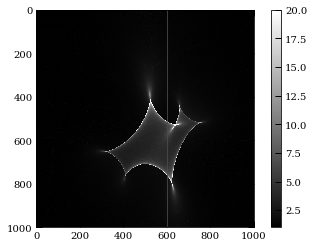

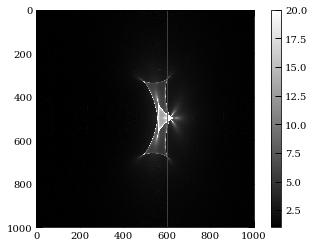

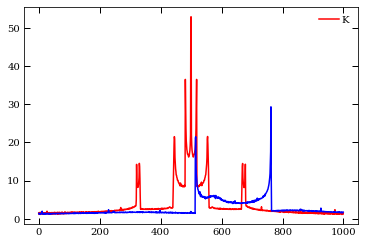

In [133]:
col = 600
plt.figure(1)
plt.imshow(mag1,interpolation='none',cmap='gray',vmin=1.0,vmax=20.0); plt.colorbar()
plt.axvline(x=col,color='red', linewidth=0.8)
plt.figure(3)
plt.imshow(mag2,interpolation='none',cmap='gray',vmin=1.0,vmax=20.0); plt.colorbar()
plt.axvline(x=col,color='red', linewidth=0.8)
plt.figure(2)
plt.plot(mag2[:,col],'r', label="K")
plt.plot(mag1[:,col],'b')
plt.legend()

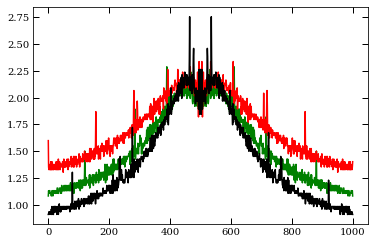

In [42]:
plt.plot(mag1[:,999],color='g')
plt.plot(mag2[:,999],color='r')
plt.plot(mag3[:,999], color='k')

In [2]:
def create_lens_ps(Day, t_0=0.5,u_0=-0.2,t_E=1.0,s=1.0,q=0.01,alpha=270,rho=0.021, K=0.0, G=0.0):
    lens = mu.model.Model(
        {'t_0': t_0, 'u_0': u_0, 't_E': t_E, 's': s, 'q': q, 'alpha': alpha, 'rho': 0, 'K': K, 
        'G': G})
    lens.set_magnification_methods([min(Day), 'point_source', max(Day)])  
    
    return lens

In [3]:
def create_lens_vbbl(Day, t_0=0.5,u_0=-0.2,t_E=1.0,s=1.0,q=0.01,alpha=270,rho=0.021, K=0.0, G=0.0):
    lens = mu.model.Model(
        {'t_0': t_0, 'u_0': u_0, 't_E': t_E, 's': s, 'q': q, 'alpha': alpha, 'rho': 0, 'K': K, 
        'G': G})
    lens.set_magnification_methods([min(Day), 'vbbl', max(Day)])  
    
    return lens

If you change the range to be larger than the range which the lens object is initialized to, the 'default magnification method' is used for points outside of the initialized range. This can be set at the top of the model.py class in MulensModel source

In [4]:
Day = np.arange(-1000,8000,1,dtype=float)
t_0 = 500.
u_0 = -0.2
t_E = 333
K = 0.0
g = 0.2
theta = np.pi/2
G = g*complex(np.cos(theta),np.sin(theta))
s = 1.0
q = 0.5
alpha = 120.0
rho = 0.0
#t_02,u_02,t_E2,alpha2 = [56889.47323336369, -0.34395072717465514, 1160.8339743043869, 262.6435463949125]

#t_0,u_0,t_E,s,q,alpha,K,G = [56744.419358138424, 0.13222441398787432, 1756.8616478646497, 0.9347452763110404, 0.73755501217656, 90.06614814426374, 0.2401154383371303, -0.06032069605176794]
# lens_vbbl1 = create_lens_vbbl(Day, t_0,u_0,t_E,s,q,alpha,rho, 0.0, G)
lens_vbbl2 = create_lens_vbbl(Day, t_0,u_0,t_E,s,q,alpha,rho, K, G)
# lens_vbbl3 = create_lens_vbbl(Day, t_0,u_0,t_E,s,q,alpha,rho, -K, G)
#lens_ps1 = create_lens_ps(Day, t_0,u_0,t_E,s,q,alpha,rho, 0.0, G)
lens_psK = create_lens_ps(Day, t_0,u_0,t_E,s,q,alpha,rho, K, G)
#lens_ps1 = create_lens_ps(Day, t_0,u_0,t_E,s,q,alpha,rho, K, complex(g,0))
#lens_vbbl1 = create_lens_vbbl(Day, t_0,u_0,t_E,s,q,alpha,rho, K, complex(g,0))
# lens_ps3 = create_lens_ps(Day, t_0,u_0,t_E,s,q,alpha,rho, -K, G)
# lens_ps2 = create_lens_ps(Day, t_02,u_02,t_E2,s,q,alpha2,rho, K+0.05, G)

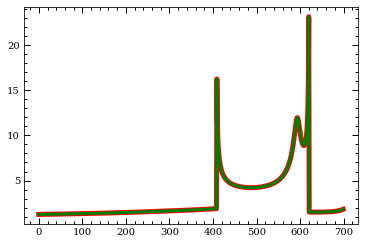

In [5]:
Day = np.arange(0,700,1,dtype=float)
#plt.ylim(0,2)
plt.minorticks_on()
plt.plot(Day, lens_psK.magnification(Day),linewidth=5,color='r',label="K")
plt.plot(Day, lens_vbbl2.magnification(Day),linewidth=3,color='g',)

#plt.plot(Day, lens_ps1.magnification(Day),linewidth=5,color='r',linestyle="--",label="K")
#plt.plot(Day, lens_vbbl1.magnification(Day),linewidth=3,color='g',linestyle="--")
#plt.plot(Day, lens_ps1.magnification(Day),linewidth=3,color='b',)
#print(np.std(lens_psK.magnification(Day) / np.sum(lens_psK.magnification(Day)) * Day))
#print(np.std(lens_ps1.magnification(Day) / np.sum(lens_ps1.magnification(Day)) * Day))
#plt.ylim(0,150)
#plt.legend()

In [ ]:
root2: 2        -0.865239       1.476222
root3: 2        -0.865239       1.476222
z: 0.134761     1.476222        -0.865239       1.476222        0.666667        0.333333
root2: 4        -0.872848       -0.519195
root3: 4        -0.872848       -0.519195
z: 0.127152     -0.519195       -0.872848       -0.519195       0.666667        0.333333
root2: 6        0.113495        -0.275199
root3: 6        0.113495        -0.275199
z: 1.113495     -0.275199       0.113495        -0.275199       0.666667        0.333333

In [ ]:
root: -22.355035        -2.963978
root: -22.754128        22.037060
root: -0.865239 1.476222
root: -1.030507 -0.005500
root: -0.872848 -0.519195
root: -0.660451 -0.282504
root: 0.113495  -0.275199
root: -0.144367 -0.279338
root: -0.007868 0.007372

In [25]:
import timeit

In [27]:
timeit.timeit(lambda : lens_psK.magnification(Day),number=50)

35.64911427302286

In [28]:
35 / 50

0.7

In [29]:
timeit.timeit(lambda : lens_vbbl2.magnification(Day),number=50) / 50

0.09032548179849982

1.000002461480476 2.040818791286604


/home/users/alpv95/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  


Text(0.5,0,'$x_s$')

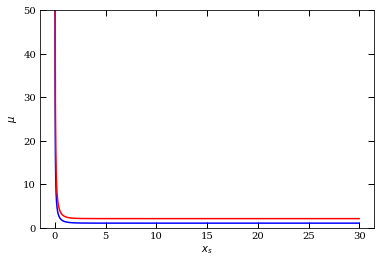

In [166]:
x_s = np.arange(0.0,30.0,0.01)
detA = lambda x, k: ((1-k)**2 - 1/x**4)**(-1)
k = 0.0
mag = []
for xs in x_s:
    x1 = (xs + np.sqrt(xs**2 + 4*(1-k))) / (2*(1-k))
    x2 = (xs - np.sqrt(xs**2 + 4*(1-k))) / (2*(1-k))
    #print(x1,x2)
    #print(1/detA(x1,k))
    mag.append(abs(detA(x1,k)) + abs(detA(x2,k)))
    
k = 0.3
mag2 = []
for xs in x_s:
    x1 = (xs + np.sqrt(xs**2 + 4*(1-k))) / (2*(1-k))
    x2 = (xs - np.sqrt(xs**2 + 4*(1-k))) / (2*(1-k))
    #print(x1,x2)
    #print(1/detA(x1,k))
    mag2.append(abs(detA(x1,k)) + abs(detA(x2,k)))
    
    
plt.plot(x_s, mag,"b")
plt.plot(x_s, mag2,"r")
print(np.min(mag), np.min(mag2))
plt.ylim(0,50)
plt.ylabel(r"$\mu$")
plt.xlabel(r"$x_s$")

In [102]:
np.max(lens_psK.magnification(Day))

10.037461005722324

(0, 10)

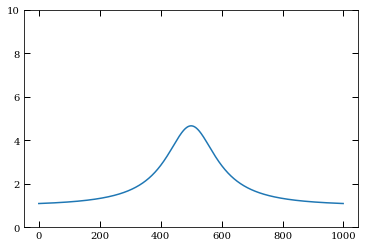

In [110]:
plt.plot(Day,lens_psK.magnification(Day))
plt.ylim(0,10)

(1, 10)

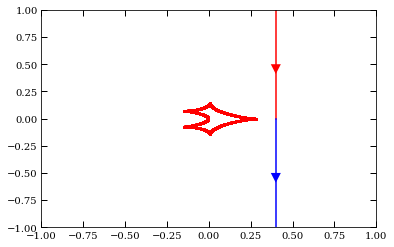

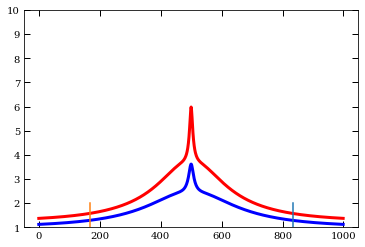

In [61]:
plt.figure(1)
square = 1.0
plt.xlim(-square,square)
plt.ylim(-square,square)
# lens_psK.plot_trajectory(t_range=[t_0 - t_E, t_0], caustics=True, color='red')
# lens_psK.plot_trajectory(t_range=[t_0, t_0 + t_E], caustics=True, color='blue')
lens_ps1.plot_trajectory(t_range=[t_0 - t_E, t_0], caustics=True, color='red')
lens_ps1.plot_trajectory(t_range=[t_0, t_0 + t_E], caustics=True, color='blue')
plt.figure(2)
plt.plot(Day, lens_psK.magnification(Day),linewidth=3,color='r',)
plt.plot(Day, lens_ps1.magnification(Day),linewidth=3,color='b',)
plt.plot([t_0 + t_E, t_0 + t_E], [1,2])
plt.plot([t_0 - t_E, t_0 - t_E], [1,2])
plt.ylim(1,10)
# plt.xlim(580,570)

In [15]:
mag1 = magpat(q=0.0,d=1.0,theta=0.0,kappa=0.0,gamma=0.0)
mag2 = magpat(q=0.0,d=1.0,theta=0.0,kappa=0.1,gamma=0.0)
mag3 = magpat(q=0.0,d=1.0,theta=0.0,kappa=-0.1,gamma=0.0)

0.1 0.0
[-0.75845967+2.15276296j -0.95259363-0.30087842j -0.1174413 -0.27630604j
  0.04169562-0.29848929j -0.85672186-0.21413888j]
[-0.75845967+2.15276296j -0.95259363-0.30087842j -0.85672186-0.21413888j
  0.04169562-0.29848929j -0.1174413 -0.27630604j]
Number of solutions:  3
0.1 0.0
[-0.75860123+2.14997468j -0.95241684-0.30137068j -0.11782319-0.27673953j
  0.04189256-0.2989463j  -0.85638699-0.21430625j]
[-0.75860123+2.14997468j -0.95241684-0.30137068j -0.85638699-0.21430625j
  0.04189256-0.2989463j  -0.11782319-0.27673953j]
Number of solutions:  3
0.1 0.0
[-0.75874332+2.14718734j -0.95223905-0.30186437j -0.11820712-0.27717441j
  0.0420908 -0.29940433j -0.85605119-0.21447368j]
[-0.75874332+2.14718734j -0.95223905-0.30186437j -0.85605119-0.21447368j
  0.0420908 -0.29940433j -0.11820712-0.27717441j]
Number of solutions:  3
0.1 0.0
[-0.75888594+2.14440094j -0.95206025-0.3023595j  -0.1185931 -0.27761071j
  0.04229035-0.29986336j -0.85571446-0.21464119j]
[-0.75888594+2.14440094j -0.9520602

0.1 0.0
[-0.77362185+1.90576401j -0.9314839 -0.35153195j -0.16246759-0.32185249j
  0.06613476-0.34351982j -0.82258868-0.22967146j]
[-0.77362185+1.90576401j -0.9314839 -0.35153195j -0.82258868-0.22967146j
  0.06613476-0.34351982j -0.16246759-0.32185249j]
Number of solutions:  3
0.1 0.0
[-0.77382198+1.90306638j -0.93117208-0.35217432j -0.16312737-0.32244468j
  0.06650372-0.34406018j -0.82216045-0.22985393j]
[-0.77382198+1.90306638j -0.93117208-0.35217432j -0.82216045-0.22985393j
  0.06650372-0.34406018j -0.16312737-0.32244468j]
Number of solutions:  3
0.1 0.0
[-0.77402292+1.90036983j -0.93085801-0.35281861j -0.1637918 -0.32303906j
  0.06687539-0.34460124j -0.82173105-0.23003679j]
[-0.77402292+1.90036983j -0.93085801-0.35281861j -0.82173105-0.23003679j
  0.06687539-0.34460124j -0.1637918 -0.32303906j]
Number of solutions:  3
0.1 0.0
[-0.77422465+1.89767434j -0.93054168-0.35346482j -0.16446093-0.32363564j
  0.0672498 -0.345143j   -0.82130046-0.23022006j]
[-0.77422465+1.89767434j -0.9305416

0.1 0.0
[-0.79507047+1.67000138j -0.89088987-0.41646321j -0.24771666-0.3841608j
 -0.77907733-0.24948497j  0.11261255-0.39274397j]
[-0.79507047+1.67000138j -0.89088987-0.41646321j -0.77907733-0.24948497j
 -0.24771666-0.3841608j   0.11261255-0.39274397j]
Number of solutions:  3
0.1 0.0
[-0.79535993+1.66740344j -0.89021213-0.4172788j  -0.24912509-0.38497949j
 -0.77850948-0.24979022j  0.11333283-0.39328198j]
[-0.79535993+1.66740344j -0.89021213-0.4172788j  -0.77850948-0.24979022j
 -0.24912509-0.38497949j  0.11333283-0.39328198j]
Number of solutions:  3
0.1 0.0
[-0.79565063+1.66480666j -0.88952677-0.41809595j -0.25054858-0.3858008j
 -0.77793918-0.25009893j  0.11405859-0.39381875j]
[-0.79565063+1.66480666j -0.88952677-0.41809595j -0.77793918-0.25009893j
 -0.25054858-0.3858008j   0.11405859-0.39381875j]
Number of solutions:  3
0.1 0.0
[-0.79594259+1.66221105j -0.88883366-0.41891462j -0.25198739-0.38662472j
 -0.7773664 -0.2504112j   0.11478986-0.39435424j]
[-0.79594259+1.66221105j -0.88883366-

 -0.40198021-0.44320111j  0.17615677-0.42396759j]
Number of solutions:  3
0.1 0.0
[-0.8183489 +1.49349121j -0.81033784-0.47143206j -0.40592383-0.44401201j
 -0.72927675-0.28916363j  0.17734496-0.42429607j]
[-0.8183489 +1.49349121j -0.81033784-0.47143206j -0.72927675-0.28916363j
 -0.40592383-0.44401201j  0.17734496-0.42429607j]
Number of solutions:  3
0.1 0.0
[-0.81874204+1.4909743j  -0.80809399-0.47198168j -0.40997201-0.44481302j
 -0.72822014-0.29040588j  0.17854147-0.42461895j]
[-0.81874204+1.4909743j  -0.80809399-0.47198168j -0.72822014-0.29040588j
 -0.40997201-0.44481302j  0.17854147-0.42461895j]
Number of solutions:  3
0.1 0.0
[-0.81913698+1.48845856j -0.80577523-0.47250356j -0.41413124-0.44560321j
 -0.72714084-0.29169816j  0.17974635-0.42493613j]
[-0.81913698+1.48845856j -0.80577523-0.47250356j -0.72714084-0.29169816j
 -0.41413124-0.44560321j  0.17974635-0.42493613j]
Number of solutions:  3
0.1 0.0
[-0.81953373+1.485944j   -0.80337606-0.47299483j -0.41840873-0.44638158j
 -0.7260373

0.1 0.0
[-0.86178341+1.27403773j -0.82904581-0.38209887j  0.3191247 -0.41727709j
 -0.71686602-0.92231603j -0.5509686 -0.17947989j]
[-0.86178341+1.27403773j -0.71686602-0.92231603j  0.3191247 -0.41727709j
 -0.82904581-0.38209887j -0.5509686 -0.17947989j]
Number of solutions:  3
0.1 0.0
[-0.86238823+1.27162301j -0.83014758-0.38237002j  0.32111987-0.41659776j
 -0.71922782-0.92723692j -0.55071955-0.17794642j]
[-0.86238823+1.27162301j -0.71922782-0.92723692j  0.32111987-0.41659776j
 -0.83014758-0.38237002j -0.55071955-0.17794642j]
Number of solutions:  3
0.1 0.0
[-0.8629962 +1.26920938j -0.83125589-0.38264834j  0.32312275-0.41590013j
 -0.72162893-0.93214493j -0.55047552-0.17642586j]
[-0.8629962 +1.26920938j -0.72162893-0.93214493j  0.32312275-0.41590013j
 -0.83125589-0.38264834j -0.55047552-0.17642586j]
Number of solutions:  3
0.1 0.0
[-0.86360734+1.26679683j -0.83237106-0.38293383j  0.32513326-0.41518403j
 -0.72406992-0.93704006j -0.55023636-0.17491786j]
[-0.86360734+1.26679683j -0.7240699

0.1 0.0
[-1.05845875-0.47755438j -0.94975705+1.02555456j -1.28257622-1.14939136j
  0.5365406 -0.21836029j -0.53886022-0.055807j  ]
[-1.28257622-1.14939136j -0.94975705+1.02555456j -1.05845875-0.47755438j
  0.5365406 -0.21836029j -0.53886022-0.055807j  ]
Number of solutions:  3
0.1 0.0
[-1.063352  -0.48015319j -0.95095755+1.02321716j -1.29019405-1.14300912j
  0.53818047-0.21509449j -0.5388187 -0.05481559j]
[-1.29019405-1.14300912j -0.95095755+1.02321716j -1.063352  -0.48015319j
  0.53818047-0.21509449j -0.5388187 -0.05481559j]
Number of solutions:  3
0.1 0.0
[-1.0683818 -0.48285641j -0.9521693 +1.02087943j -1.29770892-1.13623679j
  0.53979989-0.21180487j -0.53877802-0.05382577j]
[-1.29770892-1.13623679j -0.9521693 +1.02087943j -1.0683818 -0.48285641j
  0.53979989-0.21180487j -0.53877802-0.05382577j]
Number of solutions:  3
0.1 0.0
[-1.07355603-0.48567199j -0.95339254+1.01854132j -1.30510637-1.12906093j
  0.54139849-0.20849166j -0.53873817-0.05283751j]
[-1.30510637-1.12906093j -0.9533925

0.1 0.0
[-0.96631474-0.9951252j  -1.36843236+1.03129133j -1.13576484+0.52270824j
  0.55616003+0.17412054j -0.53838402+0.04303319j]
[-0.96631474-0.9951252j  -1.13576484+0.52270824j -1.36843236+1.03129133j
  0.55616003+0.17412054j -0.53838402+0.04303319j]
Number of solutions:  3
0.1 0.0
[-0.96496173-0.99747076j -1.36333796+1.04353502j -1.12844785+0.51800884j
  0.55478936+0.17765475j -0.53841589+0.04400769j]
[-0.96496173-0.99747076j -1.12844785+0.51800884j -1.36333796+1.04353502j
  0.55478936+0.17765475j -0.53841589+0.04400769j]
Number of solutions:  3
0.1 0.0
[-0.96362306-0.99981523j -1.35788728+1.05515367j -1.12143099+0.51359647j
  0.55339433+0.1811682j  -0.53844853+0.04498343j]
[-0.96362306-0.99981523j -1.12143099+0.51359647j -1.35788728+1.05515367j
  0.55339433+0.1811682j  -0.53844853+0.04498343j]
Number of solutions:  3
0.1 0.0
[-1.11468767+0.50943944j -0.96229841-1.0021587j  -1.35211669+1.06618275j
  0.55197527+0.18466055j -0.53848195+0.04596043j]
[-1.35211669+1.06618275j -0.9622984

0.1 0.0
[-0.87790914-1.21399115j -0.859275  +0.3910747j  -0.78918795+1.04103043j
  0.37106542+0.39439585j -0.54597104+0.14436725j]
[-0.87790914-1.21399115j -0.78918795+1.04103043j -0.859275  +0.3910747j
  0.37106542+0.39439585j -0.54597104+0.14436725j]
Number of solutions:  3
0.1 0.0
[-0.87722135-1.2163804j  -0.85793013+0.39062397j -0.78570027+1.03648902j
  0.36891716+0.39556323j -0.54613076+0.14566421j]
[-0.87722135-1.2163804j  -0.78570027+1.03648902j -0.85793013+0.39062397j
  0.36891716+0.39556323j -0.54613076+0.14566421j]
Number of solutions:  3
0.1 0.0
[-0.87653735-1.21877068j -0.85659893+0.39018137j -0.78226778+1.03192596j
  0.36677365+0.39670827j -0.54629323+0.14696865j]
[-0.87653735-1.21877068j -0.78226778+1.03192596j -0.85659893+0.39018137j
  0.36677365+0.39670827j -0.54629323+0.14696865j]
Number of solutions:  3
0.1 0.0
[-0.87585711-1.221162j   -0.85528108+0.3897468j  -0.77888971+1.02734204j
  0.36463507+0.39783114j -0.5464585 +0.14828074j]
[-0.87585711-1.221162j   -0.77888971

0.1 0.0
[-0.82699782-1.44088301j -0.72872896+0.46580386j -0.53751134+0.45606693j
 -0.69810203+0.33967239j  0.20427473+0.42974776j]
[-0.82699782-1.44088301j -0.72872896+0.46580386j -0.69810203+0.33967239j
 -0.53751134+0.45606693j  0.20427473+0.42974776j]
Number of solutions:  3
0.1 0.0
[-0.82656656-1.44337642j -0.73675224+0.46855718j -0.52609541+0.45591854j
 -0.70043733+0.33423458j  0.20290437+0.42955806j]
[-0.82656656-1.44337642j -0.73675224+0.46855718j -0.70043733+0.33423458j
 -0.52609541+0.45591854j  0.20290437+0.42955806j]
Number of solutions:  3
0.1 0.0
[-0.82613732-1.445871j   -0.74364405+0.47054872j -0.51600017+0.4557046j
 -0.70260113+0.32963658j  0.20154301+0.42936067j]
[-0.82613732-1.445871j   -0.74364405+0.47054872j -0.70260113+0.32963658j
 -0.51600017+0.4557046j   0.20154301+0.42936067j]
Number of solutions:  3
0.1 0.0
[-0.82571007-1.44836675j -0.74972764+0.47202043j -0.50687628+0.45542259j
 -0.70461925+0.32563893j  0.20019062+0.42915572j]
[-0.82571007-1.44836675j -0.74972764

0.1 0.0
[-0.79364171-1.68300845j -0.89416925+0.41240954j -0.24089171+0.38010702j
 -0.78188119+0.24800758j  0.10909193+0.39003684j]
[-0.79364171-1.68300845j -0.89416925+0.41240954j -0.78188119+0.24800758j
 -0.24089171+0.38010702j  0.10909193+0.39003684j]
Number of solutions:  3
0.1 0.0
[-0.79335962-1.68561334j -0.89480417+0.41160383j -0.23956851+0.37930427j
 -0.78243514+0.24772131j  0.10840369+0.38949226j]
[-0.79335962-1.68561334j -0.89480417+0.41160383j -0.78243514+0.24772131j
 -0.23956851+0.37930427j  0.10840369+0.38949226j]
Number of solutions:  3
0.1 0.0
[-0.79307873-1.68821939j -0.89543239+0.41079985j -0.23825873+0.37850422j
 -0.7829869 +0.24743793j  0.10772065+0.38894671j]
[-0.79307873-1.68821939j -0.89543239+0.41079985j -0.7829869 +0.24743793j
 -0.23825873+0.37850422j  0.10772065+0.38894671j]
Number of solutions:  3
0.1 0.0
[-0.79279904-1.69082659j -0.89605403+0.40999762j -0.23696214+0.37770685j
 -0.78353649+0.24715736j  0.10704278+0.38840023j]
[-0.79279904-1.69082659j -0.8960540

0.1 0.0
[-0.76744283-1.99537785j -0.94065394+0.33137217j -0.14301513+0.30347071j
  0.0553451 +0.32613294j -0.83608583+0.22382168j]
[-0.76744283-1.99537785j -0.94065394+0.33137217j -0.83608583+0.22382168j
  0.0553451 +0.32613294j -0.14301513+0.30347071j]
Number of solutions:  3
0.1 0.0
[-0.76726778-1.99811109j -0.94090155+0.33079169j -0.14248821+0.30294692j
  0.0550563 +0.32562078j -0.83647625+0.22364836j]
[-0.76726778-1.99811109j -0.94090155+0.33079169j -0.83647625+0.22364836j
  0.0550563 +0.32562078j -0.14248821+0.30294692j]
Number of solutions:  3
0.1 0.0
[-0.7670934 -2.00084535j -0.94114757+0.33021294j -0.14196457+0.30242498j
  0.05476953+0.32510954j -0.8368656 +0.22347521j]
[-0.7670934 -2.00084535j -0.94114757+0.33021294j -0.8368656 +0.22347521j
  0.05476953+0.32510954j -0.14196457+0.30242498j]
Number of solutions:  3
0.1 0.0
[-0.7669197 -2.00358064j -0.94139201+0.32963591j -0.14144417+0.30190487j
  0.05448478+0.32459923j -0.83725391+0.22330223j]
[-0.7669197 -2.00358064j -0.9413920

(400, 600)

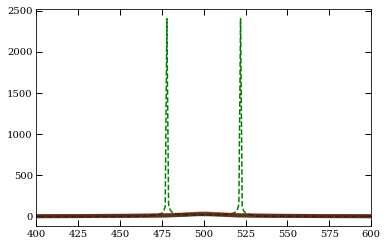

In [22]:
#plt.plot(Day, lens_vbbl.magnification(Day))
plt.plot(Day, lens_ps2.magnification(Day),'g--')
# plt.plot(Day, lens_ps2.magnification(Day),'r--')
# plt.plot(Day, lens_vbbl3.magnification(Day),'k--')

plt.plot(Day,mag1[:,510],linewidth=4,alpha=0.5, color='g')
plt.plot(Day,mag2[:,510],linewidth=4,alpha=0.5,color="r")
plt.plot(Day,mag3[:,510],linewidth=4,alpha=0.5,color="k")

plt.xlim(400,600)
# plt.ylim(1,8.2)

# plt.plot(Day,mag2[400:600,420])
# plt.plot(Day, lens_ps2.magnification(Day))
# plt.plot(Day, lens_ps2.magnification(Day) + lens_ps.magnification(Day))
#plt.plot(Data[0][15.0][0] - 52000,20*Data[0][15.0][1]+5)

/home/users/alpv95/.local/lib/python3.6/site-packages/MulensModel-1.14.26-py3.6-linux-x86_64.egg/MulensModel/binarylens.py:241: UserWarning: Convergence 0.1 is being applied!
  warnings.warn("Convergence {} is being applied!".format(K),UserWarning)
/home/users/alpv95/.local/lib/python3.6/site-packages/MulensModel-1.14.26-py3.6-linux-x86_64.egg/MulensModel/binarylens.py:353: RuntimeWarning: divide by zero encountered in true_divide
  component3 = self.mass_2 / np.conjugate(roots - self._position_z2)
/home/users/alpv95/.local/lib/python3.6/site-packages/MulensModel-1.14.26-py3.6-linux-x86_64.egg/MulensModel/binarylens.py:353: RuntimeWarning: invalid value encountered in true_divide
  component3 = self.mass_2 / np.conjugate(roots - self._position_z2)
/home/users/alpv95/.local/lib/python3.6/site-packages/MulensModel-1.14.26-py3.6-linux-x86_64.egg/MulensModel/binarylens.py:413: RuntimeWarning: divide by zero encountered in true_divide
  add_2 = self.mass_2 / (self._position_z2 - roots_ok_ba

Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being a

Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being a

Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being a

Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!


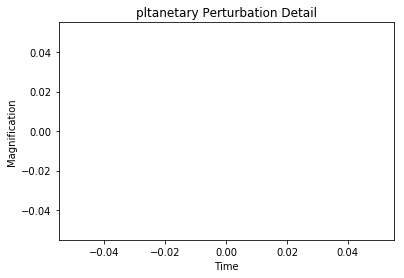

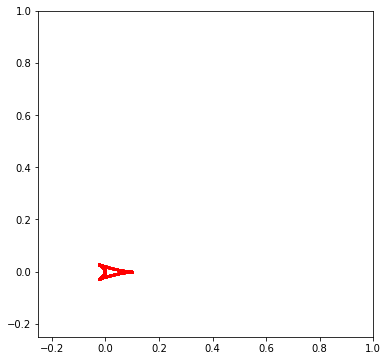

In [8]:
Day = np.arange(2000,4500,9.9)
t_0 = 3592.
u_0 = -0.32
t_E = 1200
K = 0.1
G = 0.0
s = 0.8
q = 0.01
alpha = 270.0
rho = 0.0
lens = create_lens(Day, t_0,u_0,t_E,s,q,alpha,rho, K, G)

plt.figure()
lens.plot_magnification(
    t_range=[1400., 5850.], color='red', linestyle='-', zorder=2, label='pltanet')
plt.title('pltanetary Perturbation Detail')

# pltot source trajectory and caustic
plt.figure(figsize=(6, 6))
lens.plot_trajectory(t_range=[t_0 - t_E, t_0], caustics=True, color='red')
lens.plot_trajectory(t_range=[t_0, t_0 + t_E], caustics=True, color='blue')
plt.xlim(-0.25, 1.0)
plt.ylim(-0.25, 1.0)
#plt.title('Source Trajectory')

plt.show()

In [8]:
lens.magnification(Day)

array([1.21893456, 1.22205533, 1.22522906, 1.22845685, 1.23173987,
       1.23507931, 1.23847637, 1.24193231, 1.2454484 , 1.24902595,
       1.25266632, 1.25637088, 1.26014105, 1.2639783 , 1.26788411,
       1.27186002, 1.2759076 , 1.28002848, 1.28422432, 1.28849683,
       1.29284775, 1.29727889, 1.30179211, 1.3063893 , 1.31107242,
       1.31584349, 1.32070456, 1.32565776, 1.33070527, 1.33584935,
       1.34109229, 1.34643647, 1.35188434, 1.35743842, 1.36310127,
       1.36887558, 1.37476407, 1.38076956, 1.38689496, 1.39314325,
       1.39951751, 1.4060209 , 1.41265668, 1.41942822, 1.42633897,
       1.4333925 , 1.44059248, 1.44794268, 1.45544701, 1.46310949,
       1.47093425, 1.47892556, 1.48708781, 1.49542555, 1.50394344,
       1.5126463 , 1.5215391 , 1.53062695, 1.53991514, 1.5494091 ,
       1.55911444, 1.56903696, 1.5791826 , 1.58955752, 1.60016805,
       1.61102072, 1.62212225, 1.63347958, 1.64509984, 1.6569904 ,
       1.66915881, 1.68161288, 1.69436063, 1.7074103 , 1.72077

In [97]:
Day = np.arange(3000,4000,9.9)
t_0 = 3592.
u_0 = 0.5
t_E = 600
K = 0.0
s = 1.25
q = 0.25
alpha = 270.0
rho = 0.0

for K in np.arange(0.01,0.2,0.01):
    for u_0 in np.arange(-0.3,0.8,0.05):
        lens = create_lens(Day, t_0,u_0,t_E,s,q,alpha,rho, K)
        try:
            lens.magnification(Day)
            print(K,u_0)
        except:
            continue
            
        

0.01 -0.3
0.01 -0.25
0.01 -0.2
0.01 -0.15000000000000002
0.01 -0.10000000000000003
0.01 -0.050000000000000044
0.01 -5.551115123125783e-17
0.01 0.04999999999999993
0.01 0.09999999999999992
0.01 0.1499999999999999
0.01 0.1999999999999999
0.01 0.24999999999999983
0.01 0.2999999999999999
0.01 0.3499999999999999
0.01 0.39999999999999986
0.01 0.4499999999999998
0.01 0.49999999999999983
0.01 0.5499999999999998
0.01 0.5999999999999999
0.01 0.6499999999999997
0.01 0.6999999999999997
0.01 0.7499999999999998
0.02 -0.3
0.02 -0.25
0.02 -0.2
0.02 -0.15000000000000002
0.02 -0.10000000000000003
0.02 -0.050000000000000044
0.02 -5.551115123125783e-17
0.02 0.04999999999999993
0.02 0.09999999999999992
0.02 0.1499999999999999
0.02 0.1999999999999999
0.02 0.24999999999999983
0.02 0.2999999999999999
0.02 0.3499999999999999
0.02 0.39999999999999986
0.02 0.4499999999999998
0.02 0.49999999999999983
0.02 0.5499999999999998
0.02 0.5999999999999999
0.02 0.6499999999999997
0.02 0.6999999999999997
0.02 0.74999999999

/home/users/alpv95/.local/lib/python3.6/site-packages/MulensModel-1.14.26-py3.6-linux-x86_64.egg/MulensModel/binarylens.py:228: UserWarning: Convergence 0.060000000000000005 is being applied!
  warnings.warn("Convergence {} is being applied!".format(K),UserWarning)


0.060000000000000005 -0.10000000000000003
0.060000000000000005 -0.050000000000000044
0.060000000000000005 -5.551115123125783e-17
0.060000000000000005 0.04999999999999993
0.060000000000000005 0.09999999999999992
0.060000000000000005 0.1499999999999999
0.060000000000000005 0.24999999999999983
0.060000000000000005 0.49999999999999983
0.060000000000000005 0.5499999999999998
0.060000000000000005 0.5999999999999999
0.060000000000000005 0.6499999999999997
0.060000000000000005 0.6999999999999997
0.060000000000000005 0.7499999999999998
0.06999999999999999 -0.3


/home/users/alpv95/.local/lib/python3.6/site-packages/MulensModel-1.14.26-py3.6-linux-x86_64.egg/MulensModel/binarylens.py:228: UserWarning: Convergence 0.06999999999999999 is being applied!
  warnings.warn("Convergence {} is being applied!".format(K),UserWarning)


0.06999999999999999 -0.25
0.06999999999999999 -0.2
0.06999999999999999 -0.15000000000000002
0.06999999999999999 -0.10000000000000003
0.06999999999999999 0.04999999999999993
0.06999999999999999 0.09999999999999992
0.06999999999999999 0.1999999999999999
0.06999999999999999 0.2999999999999999
0.06999999999999999 0.3499999999999999
0.06999999999999999 0.39999999999999986
0.06999999999999999 0.4499999999999998
0.06999999999999999 0.5499999999999998
0.06999999999999999 0.5999999999999999
0.06999999999999999 0.6499999999999997
0.06999999999999999 0.6999999999999997
0.06999999999999999 0.7499999999999998
0.08 -0.3
0.08 -0.25
0.08 -0.2
0.08 -0.15000000000000002


/home/users/alpv95/.local/lib/python3.6/site-packages/MulensModel-1.14.26-py3.6-linux-x86_64.egg/MulensModel/binarylens.py:228: UserWarning: Convergence 0.08 is being applied!
  warnings.warn("Convergence {} is being applied!".format(K),UserWarning)


0.08 -0.10000000000000003
0.08 -5.551115123125783e-17
0.08 0.1499999999999999
0.08 0.1999999999999999
0.08 0.2999999999999999
0.08 0.3499999999999999
0.08 0.39999999999999986
0.08 0.4499999999999998
0.08 0.49999999999999983
0.08 0.5999999999999999
0.08 0.6499999999999997
0.08 0.6999999999999997
0.08 0.7499999999999998


/home/users/alpv95/.local/lib/python3.6/site-packages/MulensModel-1.14.26-py3.6-linux-x86_64.egg/MulensModel/binarylens.py:228: UserWarning: Convergence 0.09 is being applied!
  warnings.warn("Convergence {} is being applied!".format(K),UserWarning)


0.09 -0.3
0.09 -0.25
0.09 -0.2
0.09 -0.15000000000000002
0.09 -0.10000000000000003
0.09 0.24999999999999983
0.09 0.2999999999999999
0.09 0.39999999999999986
0.09 0.4499999999999998
0.09 0.49999999999999983
0.09 0.5499999999999998
0.09 0.5999999999999999
0.09 0.6499999999999997
0.09 0.6999999999999997
0.09 0.7499999999999998
0.09999999999999999 -0.3
0.09999999999999999 -0.25
0.09999999999999999 -0.2
0.09999999999999999 -0.15000000000000002
0.09999999999999999 -0.10000000000000003


/home/users/alpv95/.local/lib/python3.6/site-packages/MulensModel-1.14.26-py3.6-linux-x86_64.egg/MulensModel/binarylens.py:228: UserWarning: Convergence 0.09999999999999999 is being applied!
  warnings.warn("Convergence {} is being applied!".format(K),UserWarning)


0.09999999999999999 -0.050000000000000044
0.09999999999999999 -5.551115123125783e-17
0.09999999999999999 0.24999999999999983
0.09999999999999999 0.39999999999999986
0.09999999999999999 0.49999999999999983
0.09999999999999999 0.5499999999999998
0.09999999999999999 0.5999999999999999
0.09999999999999999 0.6499999999999997
0.09999999999999999 0.6999999999999997
0.09999999999999999 0.7499999999999998
0.11 -0.3
0.11 -0.25


/home/users/alpv95/.local/lib/python3.6/site-packages/MulensModel-1.14.26-py3.6-linux-x86_64.egg/MulensModel/binarylens.py:228: UserWarning: Convergence 0.11 is being applied!
  warnings.warn("Convergence {} is being applied!".format(K),UserWarning)


0.11 -0.2
0.11 -0.15000000000000002
0.11 -0.10000000000000003
0.11 0.1499999999999999
0.11 0.39999999999999986
0.11 0.49999999999999983
0.11 0.5499999999999998
0.11 0.5999999999999999
0.11 0.6999999999999997
0.11 0.7499999999999998
0.12 -0.3


/home/users/alpv95/.local/lib/python3.6/site-packages/MulensModel-1.14.26-py3.6-linux-x86_64.egg/MulensModel/binarylens.py:228: UserWarning: Convergence 0.12 is being applied!
  warnings.warn("Convergence {} is being applied!".format(K),UserWarning)


0.12 -0.25
0.12 -0.2
0.12 -0.15000000000000002
0.12 -0.10000000000000003
0.12 0.3499999999999999
0.12 0.5999999999999999
0.12 0.6999999999999997
0.12 0.7499999999999998
0.13 -0.3


/home/users/alpv95/.local/lib/python3.6/site-packages/MulensModel-1.14.26-py3.6-linux-x86_64.egg/MulensModel/binarylens.py:228: UserWarning: Convergence 0.13 is being applied!
  warnings.warn("Convergence {} is being applied!".format(K),UserWarning)


0.13 -0.25
0.13 -0.2
0.13 -0.15000000000000002
0.13 -0.10000000000000003
0.13 0.5999999999999999
0.13 0.6499999999999997
0.13 0.6999999999999997
0.13 0.7499999999999998
0.14 -0.3
0.14 -0.25
0.14 -0.2
0.14 -0.15000000000000002


/home/users/alpv95/.local/lib/python3.6/site-packages/MulensModel-1.14.26-py3.6-linux-x86_64.egg/MulensModel/binarylens.py:228: UserWarning: Convergence 0.14 is being applied!
  warnings.warn("Convergence {} is being applied!".format(K),UserWarning)


0.14 -0.10000000000000003
0.14 -0.050000000000000044
0.14 0.49999999999999983
0.14 0.5499999999999998
0.14 0.6499999999999997
0.14 0.6999999999999997
0.14 0.7499999999999998
0.15000000000000002 -0.3
0.15000000000000002 -0.25
0.15000000000000002 -0.2


/home/users/alpv95/.local/lib/python3.6/site-packages/MulensModel-1.14.26-py3.6-linux-x86_64.egg/MulensModel/binarylens.py:228: UserWarning: Convergence 0.15000000000000002 is being applied!
  warnings.warn("Convergence {} is being applied!".format(K),UserWarning)


0.15000000000000002 -0.15000000000000002
0.15000000000000002 -0.10000000000000003
0.15000000000000002 -0.050000000000000044
0.15000000000000002 0.5499999999999998
0.15000000000000002 0.6499999999999997
0.15000000000000002 0.6999999999999997
0.15000000000000002 0.7499999999999998
0.16 -0.3
0.16 -0.25
0.16 -0.2


/home/users/alpv95/.local/lib/python3.6/site-packages/MulensModel-1.14.26-py3.6-linux-x86_64.egg/MulensModel/binarylens.py:228: UserWarning: Convergence 0.16 is being applied!
  warnings.warn("Convergence {} is being applied!".format(K),UserWarning)


0.16 -0.15000000000000002
0.16 -0.10000000000000003
0.16 0.5499999999999998
0.16 0.6499999999999997
0.16 0.6999999999999997
0.16 0.7499999999999998
0.17 -0.3
0.17 -0.25
0.17 -0.2


/home/users/alpv95/.local/lib/python3.6/site-packages/MulensModel-1.14.26-py3.6-linux-x86_64.egg/MulensModel/binarylens.py:228: UserWarning: Convergence 0.17 is being applied!
  warnings.warn("Convergence {} is being applied!".format(K),UserWarning)


0.17 -0.15000000000000002
0.17 -0.10000000000000003
0.17 0.5999999999999999
0.17 0.6499999999999997
0.17 0.6999999999999997
0.17 0.7499999999999998
0.18000000000000002 -0.3
0.18000000000000002 -0.25
0.18000000000000002 -0.2
0.18000000000000002 -0.15000000000000002


/home/users/alpv95/.local/lib/python3.6/site-packages/MulensModel-1.14.26-py3.6-linux-x86_64.egg/MulensModel/binarylens.py:228: UserWarning: Convergence 0.18000000000000002 is being applied!
  warnings.warn("Convergence {} is being applied!".format(K),UserWarning)


0.18000000000000002 -0.10000000000000003
0.18000000000000002 0.5999999999999999
0.18000000000000002 0.6499999999999997
0.18000000000000002 0.6999999999999997
0.18000000000000002 0.7499999999999998
0.19 -0.3
0.19 -0.25
0.19 -0.2
0.19 -0.15000000000000002
0.19 -0.10000000000000003


/home/users/alpv95/.local/lib/python3.6/site-packages/MulensModel-1.14.26-py3.6-linux-x86_64.egg/MulensModel/binarylens.py:228: UserWarning: Convergence 0.19 is being applied!
  warnings.warn("Convergence {} is being applied!".format(K),UserWarning)


0.19 0.6999999999999997
0.19 0.7499999999999998


In [ ]:
35    1    0.550753896055027653E+05
 36    2   -0.302239582955964814E+00
 37    3    0.128835491922113260E+04
 38    4    0.102978940130312702E+01
 39    5    0.165825071012847373E-01
 40    6    0.270289752889566216E+03
 41    7    0.469023645198715020E-01
 42    8    0.654406896527678361E-01
 43    9    0.568843711965567200E+05
 44   10   -0.276760797627798261E+00
 45   11    0.134480871074339325E+04
 46   12    0.261485014215465412E+03

In [12]:
Y = pd.read_csv("/home/users/alpv95/khome/SAVRot/data/PKS1413_135_all.dat",delimiter=",")

In [13]:
Columns = Y.columns
Obs = set(Y['# Observatory'])
freqs = set(Y[' Frequency (GHz)'])
print(Columns)
print(Obs)
print(freqs)

Index(['# Observatory', ' Frequency (GHz)', ' MJD', ' Flux (Jy)',
       ' Fluxerr (Jy)'],
      dtype='object')
{'Kurp', 'Iram3', 'Metsähovi', 'AMI-LA', 'UMRAO', 'OVRO (preliminary)', 'Iram4', 'OVRO', 'SMA', 'Sest', 'AMI-SA'}
{4.8, 37.0, 230.0, 8.0, 14.5, 15.0, 22.0, 345.0, 90.0}


In [81]:
MIN_DAY1 = 48835 
MAX_DAY1 = 52070
# MIN_DAY = 50800 
# MAX_DAY = 52070
Data2 = []
lower = {}
freqs = [14.5,22.0]
dt = False
DAYS = [(MIN_DAY1, MAX_DAY1)]#,(MIN_DAY2, MAX_DAY2)]
for (MIN_DAY, MAX_DAY) in DAYS:
    data_dict = {}
    for freq in freqs:
        Day = Y.loc[(Y[' Frequency (GHz)'] == freq) & (Y[' MJD'] < MAX_DAY) & (Y[' MJD'] > MIN_DAY)][' MJD']
        Flux = Y.loc[(Y[' Frequency (GHz)'] == freq) & (Y[' MJD'] < MAX_DAY) & (Y[' MJD'] > MIN_DAY)][' Flux (Jy)']
        Flux_err = Y.loc[(Y[' Frequency (GHz)'] == freq) & (Y[' MJD'] < MAX_DAY) & (Y[' MJD'] > MIN_DAY)][
            ' Fluxerr (Jy)']
        if dt and Day.to_numpy().size > 0:
            data_dict[freq] = (Day.to_numpy(), detrend(Flux.to_numpy(), bp=[np.argmin(abs(Day.to_numpy() - MIN_DAY)),
                np.argmin(abs(Day.to_numpy() - MAX_DAY))]), Flux_err.to_numpy())
            lower[freq] = data_dict[freq][1][np.argmax(Flux.to_numpy())] - np.max(Flux.to_numpy())
        else:
            data_dict[freq] = (Day.to_numpy(), Flux.to_numpy(), Flux_err.to_numpy())
            lower[freq] = 0.05
    Data2.append(data_dict)

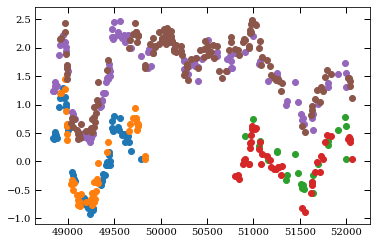

In [82]:
plt.scatter(Data[0][freqs[0]][0],Data[0][freqs[0]][1] + abs(lower[freqs[0]]))
plt.scatter(Data[0][freqs[1]][0],Data[0][freqs[1]][1] + abs(lower[freqs[1]]))

plt.scatter(Data[1][freqs[0]][0],Data[1][freqs[0]][1] + abs(lower[freqs[0]]))
plt.scatter(Data[1][freqs[1]][0],Data[1][freqs[1]][1] + abs(lower[freqs[1]]))

plt.scatter(Data2[0][freqs[0]][0],Data2[0][freqs[0]][1] + abs(lower[freqs[0]]))
plt.scatter(Data2[0][freqs[1]][0],Data2[0][freqs[1]][1] + abs(lower[freqs[1]]))
#print(np.min(Data[0][freqs[0]][1] + abs(lower)))

In [29]:
Days = []
Fluxes = []
Flux_errs = []
titles = []

for obs in list(Obs):
    for freq in list(freqs):
        Day = Y.loc[(Y['# Observatory'] == obs) & (Y[' Frequency (GHz)'] == freq)][' MJD']
        Flux = Y.loc[(Y['# Observatory'] == obs) & (Y[' Frequency (GHz)'] == freq)][' Flux (Jy)']
        Flux_err = Y.loc[(Y['# Observatory'] == obs) & (Y[' Frequency (GHz)'] == freq)][' Fluxerr (Jy)']
        
        if not Day.empty:
            Days.append(Day)
            Fluxes.append(Flux)
            Flux_errs.append(Flux_err)
            titles.append((obs,freq))

In [30]:
offsets = {"UMRAO 4.8": 0,"UMRAO 8.0": 1.5,"UMRAO 14.5": 3,"OVRO 15.0": 4.5, 
           "OVRO (preliminary) 15.0": 4.5, "AMI-LA 15.0": 4.5, "AMI-SA 15.0": 4.5,
          "Metsähovi 22.0": 4.5, "Metsähovi 37.0": 6.0, "SMA 230.0": 7.5, "SMA 345.0": 7.5, 
           "Kurp 90.0": 7, "Iram3 90.0": 7, "Iram4 90.0": 7, "Sest 90.0": 7}

0.2778 1.4802 OVRO 15.0
1.06 4.26 Iram3 90.0
1.15 2.05 Kurp 90.0
0.6141 1.0475 AMI-SA 15.0
0.01 4.55 Metsähovi 37.0
0.34 4.08 Metsähovi 22.0
0.7001 1.0353 OVRO (preliminary) 15.0
1.82 2.04 Iram4 90.0
0.25 3.24 Sest 90.0
0.15 1.46 UMRAO 4.8
0.22 2.47 UMRAO 8.0
0.3 3.86 UMRAO 14.5
0.229 1.188 SMA 230.0
0.241 0.92 SMA 345.0
0.7655 0.8343 AMI-LA 15.0


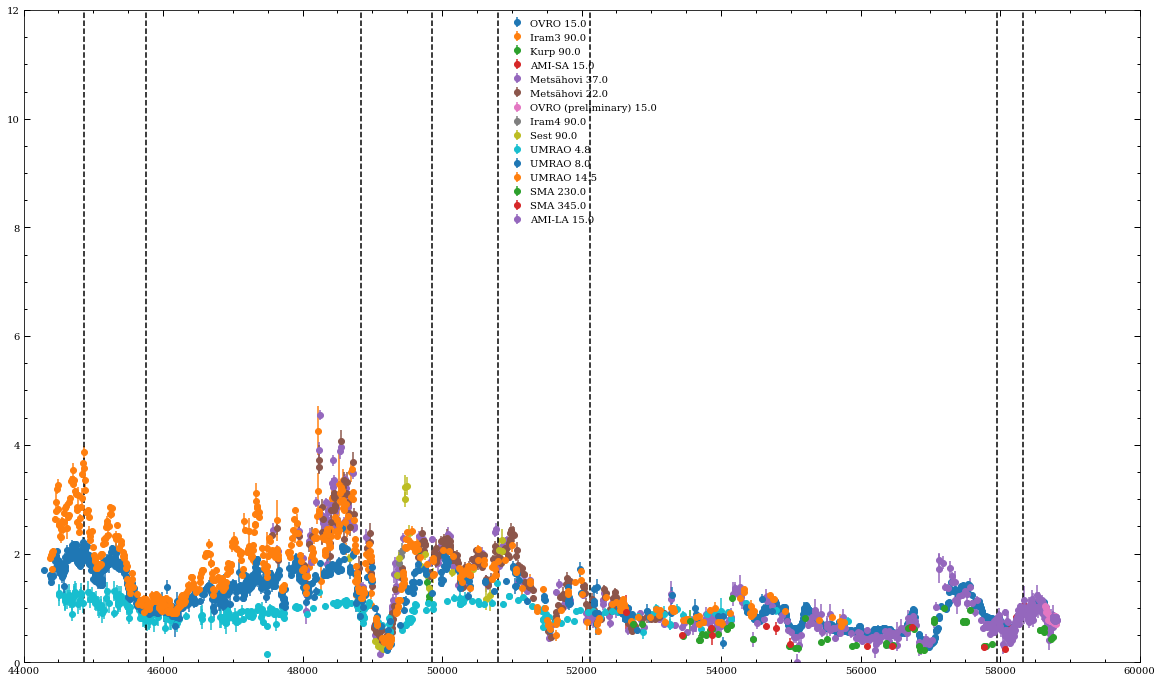

In [31]:
# MIN_DAY1 = 44790
# MAX_DAY1 = 45530
# MIN_DAY2 = 48860
# MAX_DAY2 = 49860
# MIN_DAY3 = 51100
# MAX_DAY3 = 52150

MIN_DAY0 = 44860
MAX_DAY0 = 45750
MIN_DAY1 = 48835
MAX_DAY1 = 49850
MIN_DAY2 = 50800
MAX_DAY2 = 52120
MIN_DAY3 = 57950
MAX_DAY3 = 58330
# MIN_DAY3 = 58520
# MAX_DAY3 = 59000

fig, ax = plt.subplots(figsize=(20,12))
for i, title in enumerate(titles):
#     plt.subplot(15,1,i+1)
#+ offsets[title[0]+" "+str(title[1])]
    plt.errorbar(Days[i],Fluxes[i] ,yerr=Flux_errs[i],
                 fmt='o', label="{} {}".format(title[0],title[1]))
    print(np.min(Fluxes[i]),np.max(Fluxes[i]),"{} {}".format(title[0],title[1]))
#     plt.title("Obs = {}, freq = {}".format(title[0],title[1]))
ax.legend()
ax.plot([MIN_DAY0,MIN_DAY0],[0,12],'k--')
ax.plot([MAX_DAY0,MAX_DAY0],[0,12],'k--')

ax.plot([MIN_DAY1,MIN_DAY1],[0,12],'k--')
ax.plot([MAX_DAY1,MAX_DAY1],[0,12],'k--')

ax.plot([MIN_DAY2,MIN_DAY2],[0,12],'k--')
ax.plot([MAX_DAY2,MAX_DAY2],[0,12],'k--')

ax.plot([MIN_DAY3,MIN_DAY3],[0,12],'k--')
ax.plot([MAX_DAY3,MAX_DAY3],[0,12],'k--')
ax.set_ylim(0,12)
ax.set_xlim(44000,60000)
ax.minorticks_on()

# plt.plot([MIN_DAY4,MIN_DAY4],[0,12],'k--')
# plt.plot([MAX_DAY4,MAX_DAY4],[0,12],'k--')

# plt.xlim(54000,59000)
# plt.ylim(4,5.5)

First try fitting SAV2 across all relevant bands:
- UMRAO 4.8
- UMRAO 8.0
- UMRAO 14.5
- Metsahovi 22
- Metsahovi 37
- Sest 90, Iram3 90, Iram4 90, Kurp 90


In [92]:
with open('/home/users/alpv95/khome/SAVRot/chains2_wide_single/3-_1_params.json') as json_file:
    parameters = json.load(json_file)
n_params = len(parameters)
print(n_params)
a = pymultinest.Analyzer(outputfiles_basename="/home/users/alpv95/khome/SAVRot/chains2_wide_single/3-" + '_1_', n_params = n_params)
print(a.get_best_fit())
result = a.get_best_fit()['parameters']


9
  analysing data from /home/users/alpv95/khome/SAVRot/chains2_wide_single/3-_1_.txt
{'log_likelihood': -2986.3025982095796, 'parameters': [49234.493899176225, 0.08690438085054064, 2890.746664335959, 1.167145052383314, 0.009420388224874857, 258.1648555985491, 0.19314859911289856, 0.048592819862916053, 4.199707176789506]}


In [ ]:
{'log_likelihood': -1077.3593490650078, 
 'parameters': [55052.166674191845, -0.19003521648416288, 1745.0805227132398, 
                1.108691063845681, 0.01699569739578406, 268.2825884027667, 
                0.018687120415754762, -0.06967189186594756, 3.3650862309982017, 
                56876.934023778085, -0.1690449099312683, 2095.690747471398, 259.1521987953812]}

In [25]:
print(a.get_mode_stats()["modes"][0]["sigma"][8])
print(a.get_mode_stats()["modes"][0]["maximum a posterior"][8])

5.024916886358742
56902.987712584065


In [42]:
def BIC(logl, N, n_params):
    return n_params * np.log(N) - 2*logl

def AIC(logl, n_params):
    return 2*n_params - 2*logl

def BIC_ev(logl, N, n_params):
    return  logl - n_params/2 * np.log(N)

def model_post(idx, bic_list, const):
    bic_list = np.array(bic_list) * const
    return np.exp(-0.5*bic_list[idx]) / np.sum(np.exp(-0.5*bic_list))

In [43]:
print([BIC(-1188.13, 296+90, 11), BIC(-1193.7, 296+90, 12), BIC(-1715.096350462033, 296+90, 11),BIC(-2012, 296+90, 10)])
print([BIC_ev(-1188.13, 296+90, 11), BIC_ev(-1193.7, 296+90, 12),BIC_ev(-1715.0906, 296+90, 11), BIC_ev(-2012, 296+90, 10)])
print([AIC(-1188.13, 11), AIC(-1193.7, 12),AIC(-1715.0906, 11), AIC(-2012, 10)])

[2441.7742110641134, 2458.870048433578, 3495.706911988179, 4083.5583736946483]
[-1220.8871055320567, -1229.435024216789, -1747.8477055320566, -2041.7791868473241]
[2398.26, 2411.4, 3452.1812, 4044]


creating marginal plot ...


/share/software/user/open/py-matplotlib/2.1.2_py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


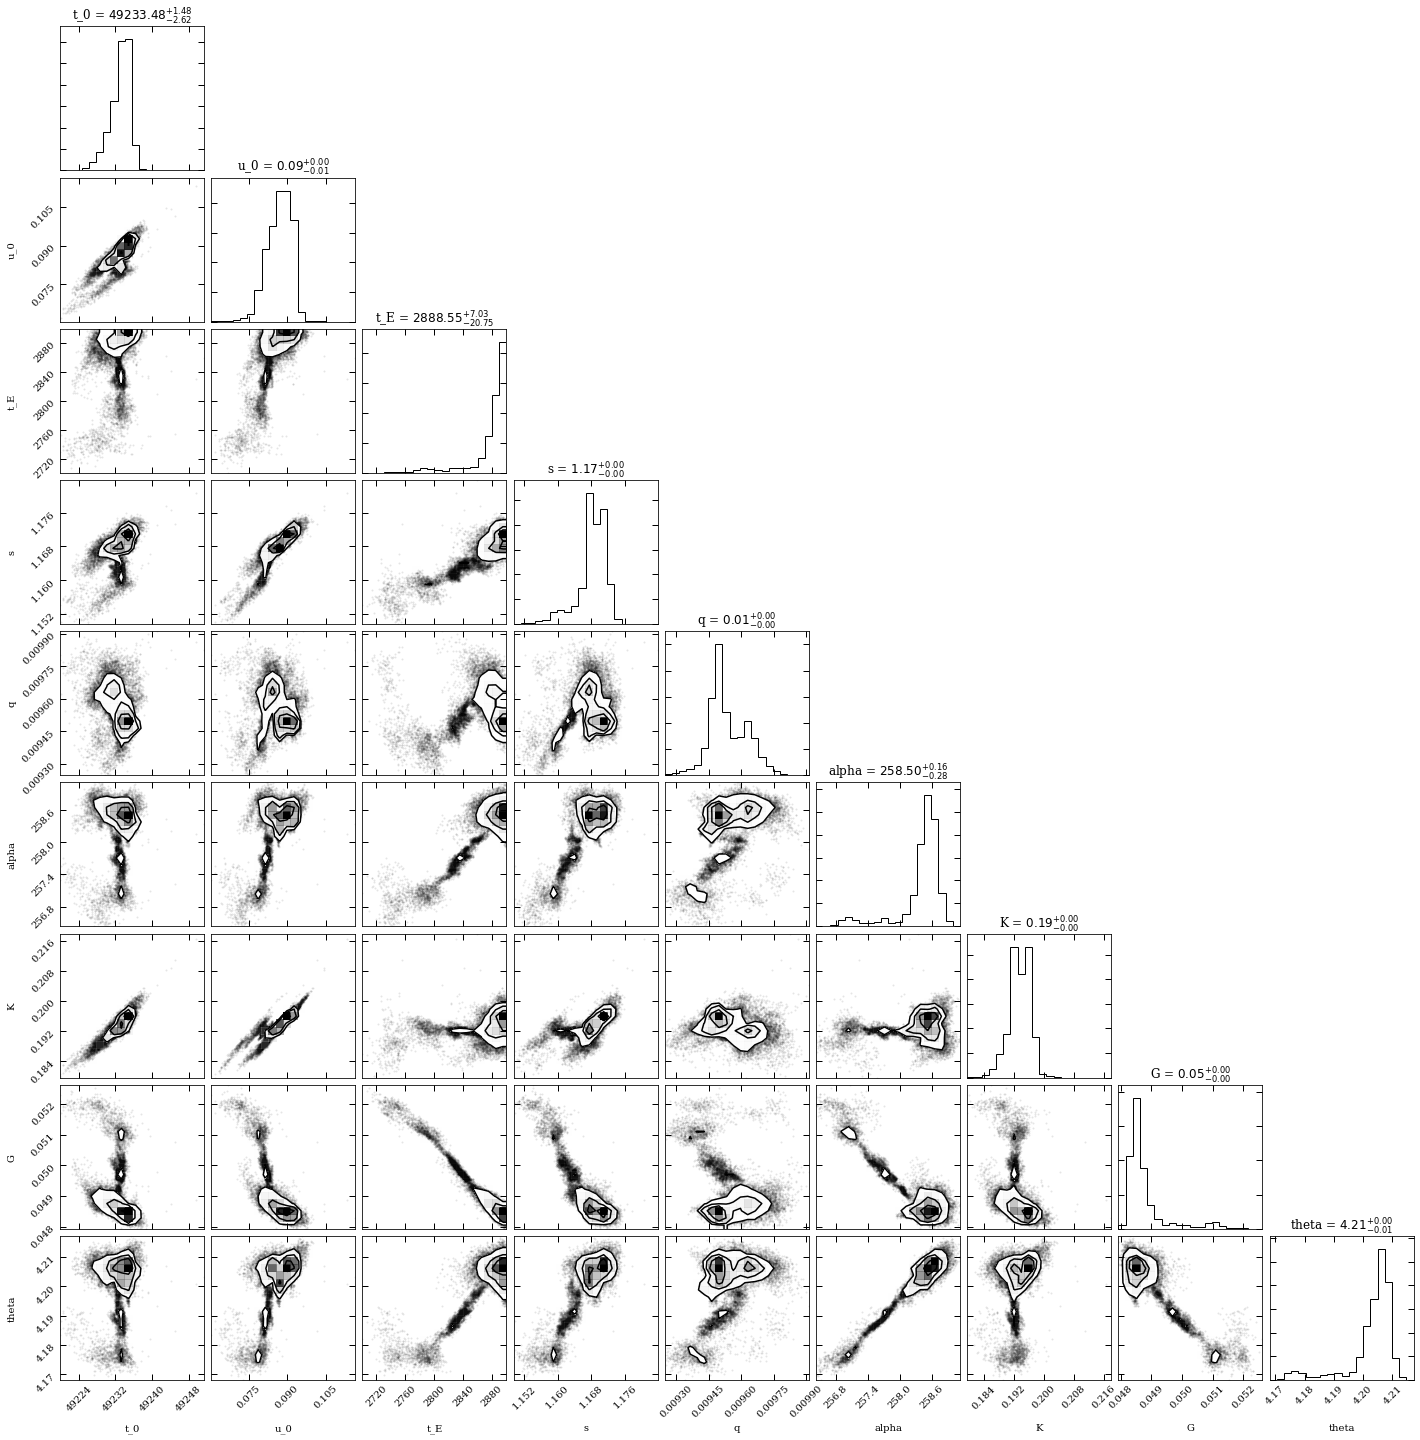

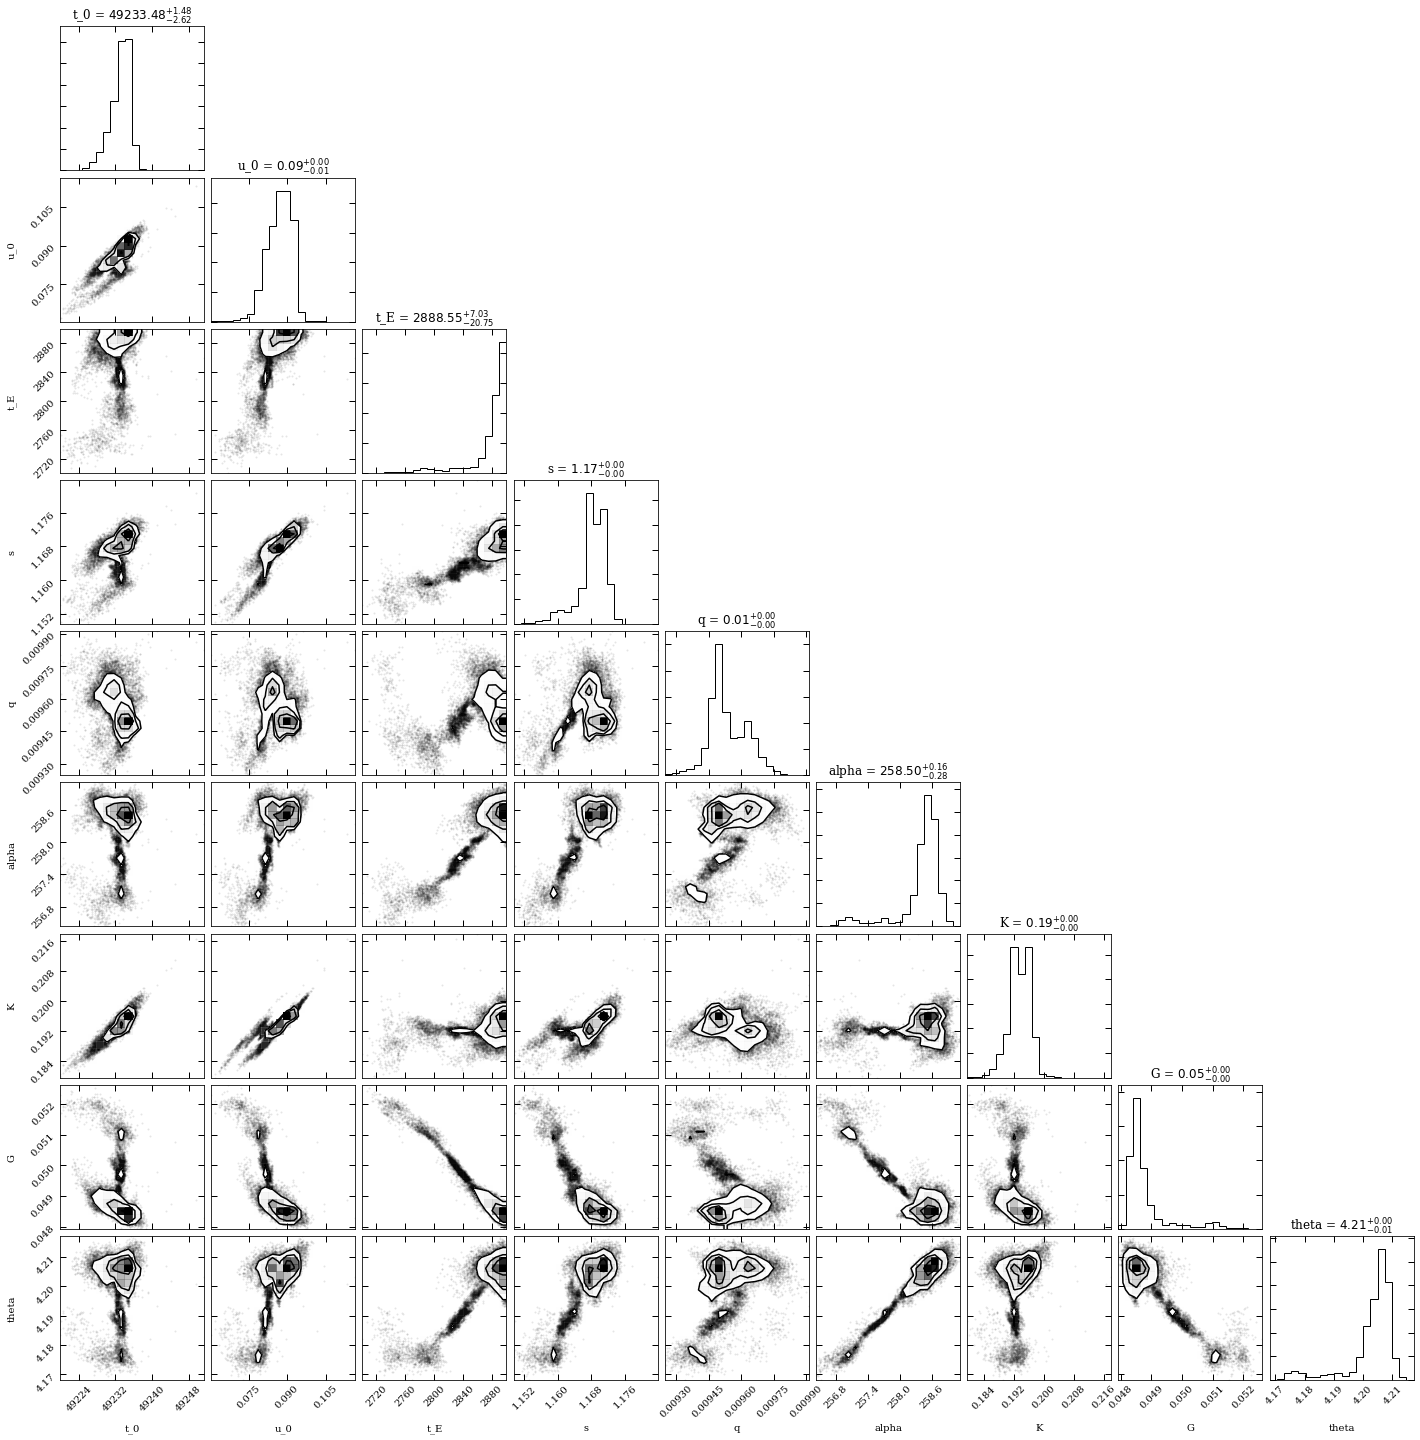

In [96]:
print('creating marginal plot ...')
#fig, ax = plt.subplots(12)
name = "45_corner"
data = a.get_data()[:,2:]
weights = a.get_data()[:,0]
#mask = weights.cumsum() > 1e-5
mask = weights  > 6e-6
corner.corner(data[mask,:], weights=weights[mask],
labels=parameters, show_titles=True, title_fmt=".2f",)
#plt.savefig("plots/" + name + ".pdf",format="pdf")

In [124]:
@contextlib.contextmanager
def nostdout():
    save_stdout = sys.stdout
    sys.stdout = io.BytesIO()
    yield
    sys.stdout = save_stdout

def create_lens(Day, t_0=0.5,u_0=-0.2,t_E=1.0,s=1.0,q=0.01,alpha=270, K=0.0, G=0.0, theta=0.0):
    lens = mu.model.Model(
        {'t_0': t_0, 'u_0': u_0, 't_E': t_E, 's': s, 'q': q, 'alpha': alpha, 'rho':0.0,'K': K, 
         'G': G*complex(np.cos(theta),np.sin(theta))})
    lens.set_magnification_methods([min(Day), 'vbbl', max(Day)])  
    
    return lens

def QPsolver(data, prediction, lower, upper, K, G):
    _, Flux, Flux_err = data

    m = len(Flux);  #dimensions
    w = np.diag(1 / Flux_err)
    b = np.matmul(w, Flux)
    if type(prediction) is tuple:
        n = 3
        constraint_M = np.array([[0, 0, 1], [1, 0, 0], [0, 1, 0]])
        Ad = np.matmul(w, np.concatenate([np.array([[p1, p2, 1]]) for p1, p2 in np.array(prediction).T], axis=0))
        l = np.hstack([b, 1e-7, 5e-5, 5e-5])
        u = np.hstack([b, upper, upper, upper])
        Ad = sparse.csc_matrix(Ad)
        A = sparse.vstack([
        sparse.hstack([Ad, -sparse.eye(m)]),
        sparse.hstack([sparse.csc_matrix(constraint_M), sparse.csc_matrix((n, m))])], format='csc')
    else:
        n=2
        constraint_M = np.array([[0, 1], [1, 0]])
        Ad = np.matmul(w, np.concatenate([np.array([[p, 1]]) for p in prediction], axis=0))
        l = np.hstack([b, 1e-7, 5e-5])
        u = np.hstack([b, upper, upper])
        Ad = sparse.csc_matrix(Ad)
        A = sparse.vstack([
        sparse.hstack([Ad, -sparse.eye(m)]),
        sparse.hstack([sparse.csc_matrix(constraint_M), sparse.csc_matrix((n, m))])], format='csc')
    
    # OSQP data
    P = sparse.block_diag([sparse.csc_matrix((n, n)), sparse.eye(m)], format='csc')
    Q = np.zeros(n + m)


#     with nostdout():
    # Create an OSQP object
    prob = osqp.OSQP()
    # Setup workspace
    prob.setup(P, Q, A, l, u, eps_rel=1e-4, polish=1)
    # Solve problem
    res = prob.solve()

    return res.x[:3], res.info.obj_val #flux_scale and loss

In [119]:
#single
def QPsolver(data, prediction, lower, upper, K, G):
    _, Flux, Flux_err = data

    m = len(Flux);  #dimensions
    w = np.diag(1 / Flux_err)
    b = np.matmul(w, Flux)
    if type(prediction) is tuple:
        n = 2
        constraint_M = np.array([[1, 0], [0, 1]])
        Ad = np.matmul(w, np.concatenate([np.array([[p1, p2]]) for p1, p2 in np.array(prediction).T], axis=0))
        l = np.hstack([b, 5e-5, 5e-5])
        u = np.hstack([b, upper, upper])
        Ad = sparse.csc_matrix(Ad)
        A = sparse.vstack([
        sparse.hstack([Ad, -sparse.eye(m)]),
        sparse.hstack([sparse.csc_matrix(constraint_M), sparse.csc_matrix((n, m))])], format='csc')
    else:
        n=1
        constraint_M = np.array([[1]])
        Ad = np.matmul(w, np.concatenate([np.array([[p]]) for p in prediction], axis=0))
        l = np.hstack([b, 5e-5])
        u = np.hstack([b, upper])
        Ad = sparse.csc_matrix(Ad)
        A = sparse.vstack([
        sparse.hstack([Ad, -sparse.eye(m)]),
        sparse.hstack([sparse.csc_matrix(constraint_M), sparse.csc_matrix((n, m))])], format='csc')
    
    # OSQP data
    P = sparse.block_diag([sparse.csc_matrix((n, n)), sparse.eye(m)], format='csc')
    Q = np.zeros(n + m)


#     with nostdout():
    # Create an OSQP object
    prob = osqp.OSQP()
    # Setup workspace
    prob.setup(P, Q, A, l, u, eps_rel=1e-4, polish=1)
    # Solve problem
    res = prob.solve()

    return res.x[:3], res.info.obj_val #flux_scale and loss

-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 49, constraints m = 49
          nnz(P) + nnz(A) = 190
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-04,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   4.48e+01   1.91e+05   1.00e-01   1.66e-04s
  50   1.1542e+03   7.29e-08   2.20e-06   1.00e-01   3.29e-04s
plsh   1.1542e+03   7.71e-15   1.67e-12   ------

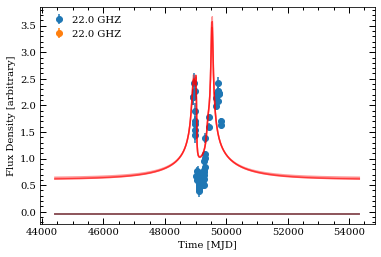

In [125]:
MIN_DAY1 = 48835 
MAX_DAY1 = 49850 
MIN_DAY2 = 0 
MAX_DAY2 = 0
#48835 52070
#54870 57190
#49850 50800
#44800 45750
MIN_DAY3 = 58520
MAX_DAY3 = 59000

Y = pd.read_csv("/home/users/alpv95/khome/SAVRot/data/PKS1413_135_all.dat", delimiter=",")

#freqs = [15.0,37.0] #[4.8,8.0,14.5,15.0,22.0,37.0]
freqs = [22.0]
offsets = {4.8: 0, 8.0: 1.5, 14.5: 3, 15.0: 4.5,
          22.0: 4.5, 37.0: 6.0, 230.0: 7.5, 345.0: 7.5,
           90.0: 7,}

Data1 = {}
Data2 = {}
Data3 = {}
Data_plot = {}
lower = {}
dt = False
for freq in freqs:
    Day1 = Y.loc[(Y[' Frequency (GHz)'] == freq) & (Y[' MJD'] < MAX_DAY1) & (Y[' MJD'] > MIN_DAY1)][' MJD']
    Flux1 = Y.loc[(Y[' Frequency (GHz)'] == freq) & (Y[' MJD'] < MAX_DAY1) & (Y[' MJD'] > MIN_DAY1)][' Flux (Jy)']
    Flux_err1 = Y.loc[(Y[' Frequency (GHz)'] == freq) & (Y[' MJD'] < MAX_DAY1) & (Y[' MJD'] > MIN_DAY1)][' Fluxerr (Jy)']

    Day2 = Y.loc[(Y[' Frequency (GHz)'] == freq) & (Y[' MJD'] < MAX_DAY2) & (Y[' MJD'] > MIN_DAY2)][' MJD']
    Flux2 = Y.loc[(Y[' Frequency (GHz)'] == freq) & (Y[' MJD'] < MAX_DAY2) & (Y[' MJD'] > MIN_DAY2)][' Flux (Jy)']
    Flux_err2 = Y.loc[(Y[' Frequency (GHz)'] == freq) & (Y[' MJD'] < MAX_DAY2) & (Y[' MJD'] > MIN_DAY2)][' Fluxerr (Jy)']

    Day3 = Y.loc[(Y[' Frequency (GHz)'] == freq) & (Y[' MJD'] < MAX_DAY3) & (Y[' MJD'] > MIN_DAY3)][' MJD']
    Flux3 = Y.loc[(Y[' Frequency (GHz)'] == freq) & (Y[' MJD'] < MAX_DAY3) & (Y[' MJD'] > MIN_DAY3)][' Flux (Jy)']
    Flux_err3 = Y.loc[(Y[' Frequency (GHz)'] == freq) & (Y[' MJD'] < MAX_DAY3) & (Y[' MJD'] > MIN_DAY3)][' Fluxerr (Jy)']
    
    Dayp = Y.loc[Y[' Frequency (GHz)'] == freq][' MJD']
    Fluxp = Y.loc[Y[' Frequency (GHz)'] == freq][' Flux (Jy)']
    Flux_errp = Y.loc[Y[' Frequency (GHz)'] == freq][' Fluxerr (Jy)']


    if not Dayp.empty:
        if dt:
            flux_detrend = detrend(Flux1.to_numpy(), bp=[np.argmin(abs(Day1.to_numpy() - MIN_DAY1)),
                    np.argmin(abs(Day1.to_numpy() - MAX_DAY1))])
            lower[freq] = flux_detrend[np.argmax(Flux1.to_numpy())] - np.max(Flux1.to_numpy())
            Data1[freq] = ( Day1.to_numpy(),flux_detrend + abs(lower[freq]), Flux_err1.to_numpy() )
            
            if Day2.to_numpy().size:
                flux_detrend = detrend(Flux2.to_numpy(), bp=[np.argmin(abs(Day2.to_numpy() - MIN_DAY2)),
                        np.argmin(abs(Day2.to_numpy() - MAX_DAY2))])
                lower[freq] = flux_detrend[np.argmax(Flux2.to_numpy())] - np.max(Flux2.to_numpy())
                Data1[freq] = ( Day2.to_numpy(), flux_detrend + abs(lower[freq]), Flux_err2.to_numpy() )
            else:
                Data2[freq] = ( Day2.to_numpy(), Flux2.to_numpy(), Flux_err2.to_numpy() )
                
            #lower[freq] = Data1[freq][1][np.argmax(Flux1.to_numpy())] - np.max(Flux1.to_numpy())
            #lower[freq] = Data1[freq][1][np.argmin(Flux1.to_numpy())] - np.min(Flux1.to_numpy()) - 0.15

        else:
            Data1[freq] = ( Day1.to_numpy(),Flux1.to_numpy()+0.05, Flux_err1.to_numpy() )
            Data2[freq] = ( Day2.to_numpy(), Flux2.to_numpy()+0.05, Flux_err2.to_numpy() )
#             Data3[freq] = ( Day3.to_numpy(), Flux3.to_numpy(), Flux_err3.to_numpy() )
            Data_plot[freq] = (Dayp.to_numpy(), Fluxp.to_numpy()+0.05, Flux_errp.to_numpy())
            lower[freq] = -0.05
    

fig, ax = plt.subplots()
name = "45dt"
for i, freq in enumerate(freqs):
    Day1, Flux1, Flux_err1 = Data1[freq]
    Day2, Flux2, Flux_err2 = Data2[freq]
#     Dayp, Fluxp, Flux_errp = Data_plot[freq]
    ax.errorbar(Day1,Flux1,yerr=Flux_err1,
                 fmt='o', label="{} GHZ".format(freq))
    ax.errorbar(Day2,Flux2,yerr=Flux_err2,
                 fmt='o', label="{} GHZ".format(freq))
    Day = np.linspace(min(Day1)-4500,max(Day1)+4500,500) #for smooth full lens plot
    upper = np.mean(Data1[freq][1]) - 1*np.std(Data1[freq][1])
    G = 0.0
    K = 0.0
    toff = 0.0
    theta = 0.0
    #t_02, u_02, t_E2, alpha2
    for (t_0, u_0, t_E, s, q, alpha, K, G, theta) in a.get_equal_weighted_posterior()[::6000, :-1]:
        Day1, _, _ = Data1[freq]
        Day2, _, _ = Data2[freq]
#         Day3, _, _ = Data3[freq]

        if Day2.size:
            if i:
                t_0 += toff
                t_02 += toff
        
            if (Day1.size == Day2.size) and (Day1 == Day2).all():
                Day_current = Day1
                Data_current = Data1[freq]
            else:
                Day_current = np.concatenate((Day1,Day2))
                Data_concat = np.hstack((Data1[freq], Data2[freq]))
                Data_current = (Data_concat[0],Data_concat[1],Data_concat[2])
    
            
            lens1 = create_lens(Day_current, t_0, u_0, t_E, s, q, alpha, K, G, theta)
            lens2 = create_lens(Day_current, t_02, u_02, t_E2, s, q, alpha2, K, G, theta)
            p_hat1 = lens1.magnification(Day_current)
            p_hat2 = lens2.magnification(Day_current)            
            flux_scale1, _ = QPsolver(Data_current, (p_hat1, p_hat2), lower[freq], upper, K, G)

            lens1 = create_lens(Day, t_0, u_0, t_E, s, q, alpha,  K,G, theta)
            lens2 = create_lens(Day, t_02, u_02, t_E2, s, q, alpha2,  K,G, theta)
            p_hat_plot1 = lens1.magnification(Day)
            p_hat_plot2 = lens2.magnification(Day)
        
            ax.plot(Day, flux_scale1[0] * p_hat_plot1 + flux_scale1[1] * p_hat_plot2 + flux_scale1[2] 
                  , alpha=0.4, color='r',zorder=10)
            ax.plot(Day, flux_scale1[0] * p_hat_plot1 + flux_scale1[2] 
              , alpha=0.3, color='g')
            ax.plot(Day,flux_scale1[1] * p_hat_plot2 + flux_scale1[2]
               , alpha=0.3, color='g')
            ax.plot([min(Day),max(Day)],[lower[freq],lower[freq]])
            #ax.plot([53000,57000],[upper,upper])
            
        elif Day1.size and not Day2.size:
            lens1 = create_lens(Day1, t_0, u_0, t_E, s, q, alpha, K, G, theta)
            p_hat1 = lens1.magnification(Day1)
            flux_scale1, _ = QPsolver(Data1[freq], p_hat1, lower[freq], upper, K, G)
            
            lens1 = create_lens(Day, t_0, u_0, t_E, s, q, alpha,  K,G, theta)
            p_hat_plot1 = lens1.magnification(Day)
            
            ax.plot(Day, flux_scale1[0] * p_hat_plot1 + flux_scale1[1]
                 , alpha=0.4, color='r',zorder=10)
            ax.plot([min(Day),max(Day)],[lower[freq],lower[freq]])

leg = ax.legend(loc = 2,)
for line, text in zip(leg.get_lines(), leg.get_texts()):
    text.set_color(line.get_color())
#ax.set_ylim(ymin=-3,ymax=2.0)
# ax.set_xlim(44500,46000)
ax.set_xlabel(r"Time [MJD]")
ax.set_ylabel(r"Flux Density [arbitrary]")
ax.minorticks_on()
plt.savefig("plots/" + name + ".pdf",format="pdf")

<Container object of 3 artists>

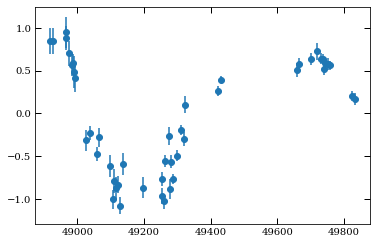

In [45]:
plt.errorbar(Day1,np.log(Flux1 - np.min(Flux1) + 0.34),yerr=Flux_err1,
                 fmt='o', label="{} GHZ".format(freq))
# plt.plot(np.log(2*p_hat_plot1),'b')
# plt.plot(2*np.log(p_hat_plot1),'r')
# plt.plot(np.log(p_hat_plot1),'g')

In [113]:
flux_scale1[1]


9.99998503625203e-08

15.129199353850508


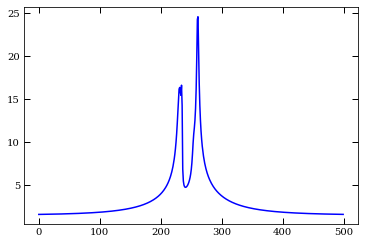

In [110]:
plt.plot(p_hat_plot1,'b')
print(np.max(p_hat_plot1)/np.min(p_hat_plot1))

## Best Fit Parameters

In [48]:
print(LOSS)
print(0.5*np.sum(abs((Data_current[1]) - (5*flux_scale1[0] * p_hat1 + 5*flux_scale1[1] * p_hat2 -0.4 + flux_scale1[2]))**2 / (Data_current[2])**2))
print(0.5*np.sum(abs((Data_current[1]) - (flux_scale1[0] * p_hat1 + flux_scale1[1] * p_hat2 + flux_scale1[2]))**2 / (Data_current[2])**2))      

prediction = (p_hat1,p_hat2)
Flux = Data_current[1]
Flux_err = Data_current[2]

m = len(Flux);  #dimensions
w = np.diag(1 / Flux_err)
b = np.matmul(w, Flux)
Ad = np.matmul(w, np.concatenate([np.array([[p1, p2, 1]]) for p1, p2 in np.array(prediction).T], axis=0))

x = np.linalg.lstsq(Ad,b)
print(0.5*np.sum(abs((Data_current[1]) - (x[0][0] * p_hat1 + x[0][1] * p_hat2 + x[0][2]))**2 / (Data_current[2])**2))
print(x[1])
print(x[0])

2234.0898474600144
783374.6720308524
2234.0898474600176
2234.089847460018
[4468.17969492]
[ 0.09349927  0.10790663 -0.36315529]


/home/users/alpv95/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


In [9]:
freq = 14.5
Day, Flux, Flux_err = Data_plot[freq]
lower = np.min(Flux)
upper = np.max(Flux)

(t_0, u_0, t_E, s, q, alpha, rho, t_02, u_02, t_E2, alpha2) = result
Day2, Flux2, Flux_err2 = Data2[freq]
lens2 = create_lens(Day2, t_02, u_02, t_E2, s, q, alpha2, rho)
p_hat2 = lens2.magnification(Day2)

# Generate problem data
m = len(Flux2)
n = 2
#Ad = sparse.random(m, n, density=0.7, format='csc')
w = np.diag(1 / Flux_err2)
Ad = np.matmul(w, np.concatenate([np.array([[p, 1]]) for p in p_hat2], axis=0))
Ad = sparse.csc_matrix(Ad)
b = np.matmul(w,Flux2)
constraint_M = np.array([[1, 1],[1, 0]])

# OSQP data
P = sparse.block_diag([sparse.csc_matrix((n, n)), sparse.eye(m)], format='csc')
Q = np.zeros(n+m)
A = sparse.vstack([
        sparse.hstack([Ad, -sparse.eye(m)]),
        sparse.hstack([sparse.csc_matrix(constraint_M), sparse.csc_matrix((n, m))])], format='csc')
l = np.hstack([b, lower, -np.inf])
u = np.hstack([b, upper, 0])

# Create an OSQP object
prob = osqp.OSQP()

with nostdout():
    # Setup workspace
    prob.setup(P, Q, A, l, u)
    
    # Solve problem
    res = prob.solve()

KeyError: 14.5

In [108]:
res.info.obj_val

15951.658358507946

In [98]:
flux_scale2 = res.x[:2]

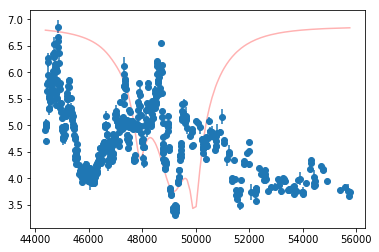

In [99]:
lens2 = create_lens(Day, t_02, u_02, t_E2, s, q, alpha2, rho)
p_hat_plot = lens2.magnification(Day)

plt.errorbar(Day,Flux + offsets[freq],yerr=Flux_err,
                 fmt='o', label="{} GHZ".format(freq))
plt.plot(Day, flux_scale2[0] * p_hat_plot + flux_scale2[1] + offsets[freq], alpha=0.3, color='r')

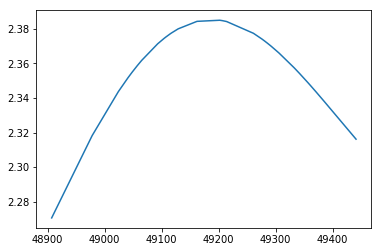

In [58]:
plt.plot(Day2,p_hat2)

<Container object of 3 artists>

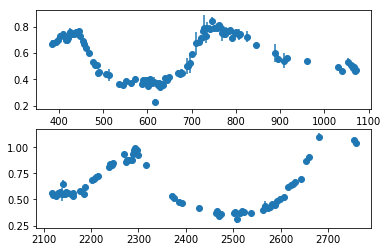

In [3]:
X = np.loadtxt("/home/users/alpv95/khome/Yannis/data/data_tofit.csv",delimiter=',')
Day = X[:,0]
Flux = X[:,1]
Flux_err = X[:,2]

Day1 = X[49:152,0] #[49:152] [40:152]
Flux1 = X[49:152,1]
Flux_err1 = X[49:152,2]

plt.subplot(211)
plt.errorbar(Day1,Flux1,yerr=Flux_err1,fmt="o")

Day2 = X[290:362,0] #[290:361] 290:362
Flux2 = X[290:362,1]
Flux_err2 = X[290:362,2]

plt.subplot(212)
plt.errorbar(Day2,Flux2,yerr=Flux_err2,fmt="o")

In [4]:
def create_lens(t_0=0.5,u_0=-0.2,t_E=1.0,s=1.0,q=0.01,alpha=270,rho=0.021,ds_dt=0,dalpha_dt=0):
    # Create a PSPL model
    lens = mu.model.Model(
        {'t_0': t_0, 'u_0': u_0, 't_E': t_E, 's': s, 'q': q, 'alpha': alpha,
         'rho': rho,'ds_dt':ds_dt, 'dalpha_dt': dalpha_dt})
    lens.set_magnification_methods([min(Day), 'VBBL', max(Day)])
    
    return lens
    
def normalize_data(lightcurve):
    lightcurve[:,0] = (lightcurve[:,0] - np.min(lightcurve[:,0])) / (np.max(lightcurve[:,0]) - np.min(lightcurve[:,0]))
    lightcurve[:,1] = (lightcurve[:,1] - np.min(lightcurve[:,1])) / (np.max(lightcurve[:,1]) - np.min(lightcurve[:,1]))
    return lightcurve

<Container object of 3 artists>

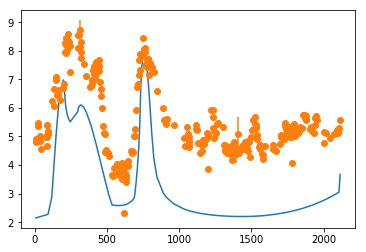

In [31]:
lens, lens2 = create_lens(t_0=446.6580144973914,u_0=-0.1809695283892867,t_E=1267.6154050685568,s=0.8028855935030114,q=0.2916910349903737,alpha=34.96229255002339,rho=0.022690101950104014,ds_dt=0)
plt.plot(Day,0.5*lens.magnification(Day) + lens2.magnification(Day) )
plt.errorbar(Day,10*Flux,yerr=Flux_err,fmt="o")


Text(0.5,1,'Source Trajectory')

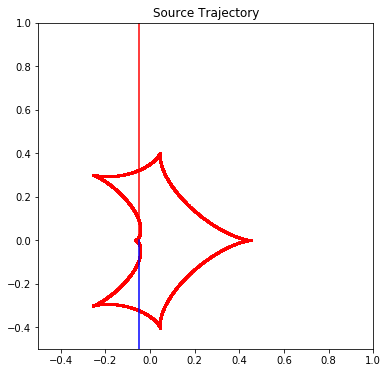

In [5]:
plt.figure(figsize=(6, 6))
t_0=1500; t_E=1500;
lens.plot_trajectory(t_range=[t_0 - t_E, t_0], caustics=True, color='red')
lens.plot_trajectory(t_range=[t_0, t_0 + t_E], caustics=True, color='blue')
plt.xlim(-0.5, 1.0)
plt.ylim(-0.5, 1.0)
plt.title('Source Trajectory')

In [6]:
def prior(cube, ndim, nparams):
    #t_0=0.5,u_0=-0.18,t_E=0.5,s=1,q=0.1,alpha=270,rho=0.01
    cube[0] = cube[0] * (max(Day) - min(Day)) + min(Day)
    cube[1] = cube[1]*0.8 - 0.4
    cube[2] = cube[2] * (max(Day) - min(Day)) + (max(Day) - min(Day))/4 #offset
    cube[3] = cube[3] * 0.4 + 0.8
    cube[4] = cube[4] * 0.4 + 0.01
    cube[5] = cube[5] * 360
    cube[6] = 10**(cube[6]*4 - 5) #flux_offset
    return cube

In [7]:
def loglike(cube, ndim, nparams):
    t_0, u_0, t_E, s, q, alpha, rho = cube[0], cube[1], cube[2], cube[3], cube[4], cube[5], cube[6]
    lens = create_lens(t_0, u_0, t_E, s, q, alpha, rho)
    p_hat = lens.magnification(Day)
    #Do linear regression to find optimal axis value here

    A = np.concatenate([np.array([[p,1]]) for p in p_hat],axis=0)
    w = np.diag(1 / Flux_err)
    b = Flux
    flux_scale, loss_flux, _, _ = np.linalg.lstsq(np.matmul(w,A),np.matmul(w,b))

    return -loss_flux 

In [8]:
try: os.mkdir('chains')
except OSError: pass

In [18]:
with open('/home/users/alpv95/khome/Yannis/chains3/3-_1_params.json') as json_file:
    parameters = json.load(json_file)
n_params = len(parameters)
print(n_params)
a = pymultinest.Analyzer(outputfiles_basename="/home/users/alpv95/khome/Yannis/chains3/3-" + '_1_', n_params = n_params)
print(a.get_best_fit())
result = a.get_best_fit()['parameters']



11
  analysing data from /home/users/alpv95/khome/Yannis/chains3/3-_1_.txt
{'log_likelihood': -9.973014673293484, 'parameters': [925.9799786886877, 0.21919076797284853, 1407.5551554413069, 0.9741548196332227, 0.6831904175335324, 209.60040944093586, 0.028138878777743744, 2738.7571292859643, -0.2089969709502533, 1916.711050442986, 321.06045323653893]}


In [56]:
1916/365

5.249315068493151

In [5]:
a.get_equal_weighted_posterior()[-1,:-1]

array([ 9.19312534e+02,  1.48511977e-01,  1.90628903e+03,  7.89803810e-01,
        2.60505761e-01,  1.19178740e+02,  3.22720063e-02,  2.40200851e+03,
       -1.42719024e-01,  1.98980985e+03,  2.98921572e+02])

In [22]:
S = []
Q = []
for (t_0, u_0, t_E, s, q, alpha, rho, t_02, u_02, t_E2, alpha2) in a.get_equal_weighted_posterior()[::2,:-1]:
    S.append(s)
    Q.append(q)

Text(0,0.5,'q')

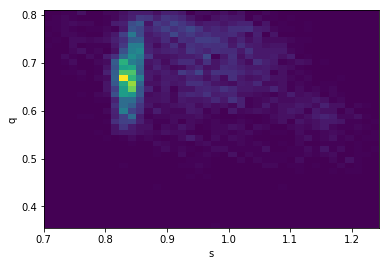

In [52]:
plt.hist2d(S,Q, bins=40,)
plt.xlabel("s")
plt.ylabel("q")

(array([0.07532382, 0.18292927, 0.69943545, 0.93616745, 0.98997018,
        0.90388582, 0.85008309, 0.76399873, 0.64563273, 0.83932255,
        1.14061782, 1.11909673, 0.75323818, 0.79628036, 0.78551982,
        0.67791436, 0.50574564, 0.38737964, 0.710196  , 1.420392  ,
        2.17363018, 3.42185346, 4.67007673, 4.47638691, 4.64855564,
        3.72314873, 3.68010655, 3.06675546, 2.76546018, 2.92686836,
        2.49644655, 1.99070091, 1.92613764, 1.76472946, 1.538758  ,
        1.15137836, 0.44118236, 0.08608436, 0.07532382, 0.02152109]),
 array([0.60928198, 0.62535186, 0.64142173, 0.65749161, 0.67356149,
        0.68963136, 0.70570124, 0.72177111, 0.73784099, 0.75391087,
        0.76998074, 0.78605062, 0.80212049, 0.81819037, 0.83426024,
        0.85033012, 0.8664    , 0.88246987, 0.89853975, 0.91460962,
        0.9306795 , 0.94674938, 0.96281925, 0.97888913, 0.994959  ,
        1.01102888, 1.02709875, 1.04316863, 1.05923851, 1.07530838,
        1.09137826, 1.10744813, 1.12351801, 1.

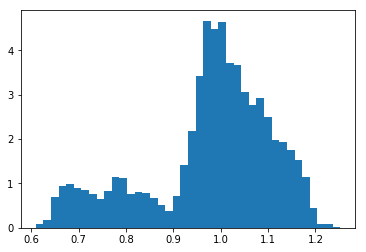

In [23]:
plt.hist(S, bins=40,density=True)

/home/users/alpv95/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/users/alpv95/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


[14.0710857] [12.9948037]
[6.54899525] [11.3968793]
[5.98086775] [12.75477238]
[7.32688285] [8.19419836]
[6.87072692] [9.07446902]
[5.16054682] [9.50383518]
[4.6919129] [9.66595276]
[4.43970462] [8.45787077]
[4.0408316] [10.68316819]
[4.72264473] [7.85138659]
[3.7559789] [7.96379944]
[3.96901738] [6.97644581]


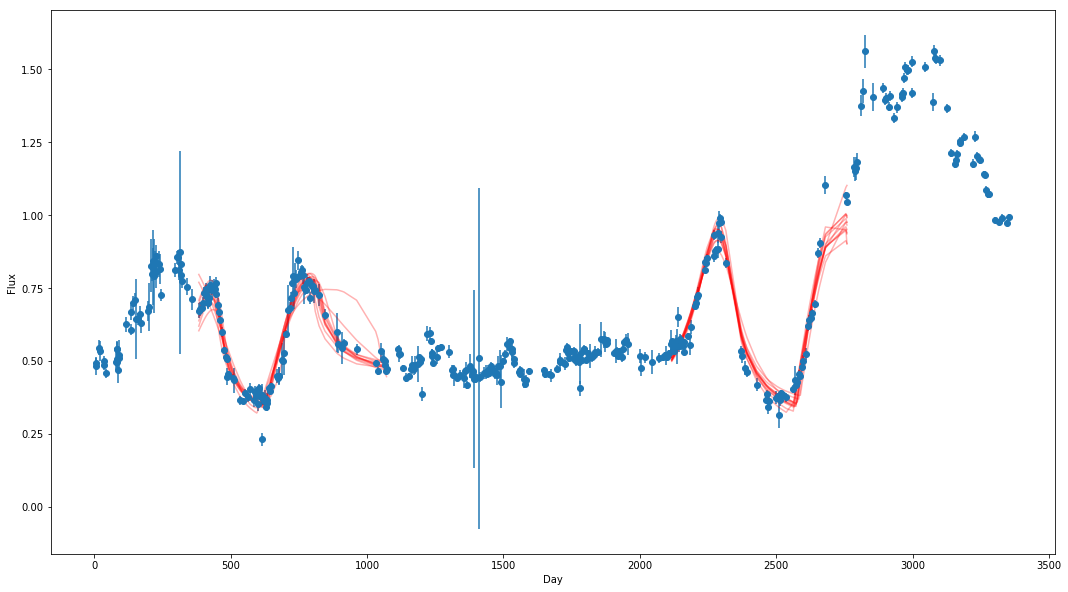

In [27]:
plt.figure(figsize=(18,10))
#plt.subplot(211)
plt.errorbar(Day,Flux,yerr=Flux_err,fmt="o")
plt.xlabel("Day")
plt.ylabel("Flux")

for (t_0, u_0, t_E, s, q, alpha, rho, t_02, u_02, t_E2, alpha2) in a.get_equal_weighted_posterior()[::1000,:-1]:
    
    #t_0, u_0, t_E, s, q, alpha, rho, t_02, u_02, t_E2, alpha2 = result
    lens1 = create_lens(t_0, u_0, t_E, s, q, alpha, rho)
    lens2 = create_lens(t_02, u_02, t_E2, s, q, alpha2, rho)
    p_hat1 = lens1.magnification(Day1) 
    p_hat2 = lens2.magnification(Day2)
    #Do linear regression to find optimal axis value here

    A = np.concatenate([np.array([[p,1]]) for p in p_hat1],axis=0)
    w = np.diag(1 / Flux_err1)
    b = Flux1
    flux_scale1, loss_flux1, _, _ = np.linalg.lstsq(np.matmul(w,A),np.matmul(w,b))
    plt.plot(Day1,flux_scale1[0]*p_hat1 + flux_scale1[1], alpha=0.3,color='r')
    
    A = np.concatenate([np.array([[p,1]]) for p in p_hat2],axis=0)
    w = np.diag(1 / Flux_err2)
    b = Flux2
    flux_scale2, loss_flux2, _, _ = np.linalg.lstsq(np.matmul(w,A),np.matmul(w,b))
    plt.plot(Day2,flux_scale2[0]*p_hat2 + flux_scale2[1], alpha=0.3,color='r')
    print(loss_flux1 / len(Day1),loss_flux2 / len(Day2))
    
    
# plt.subplot(212)
# plt.plot([400,2700],[0,0],"--")

# t_0, u_0, t_E, s, q, alpha, rho, t_02, u_02, t_E2, alpha2 = result
# lens1 = create_lens(t_0, u_0, t_E, s, q, alpha, rho)
# lens2 = create_lens(t_02, u_02, t_E2, s, q, alpha2, rho)
# p_hat1 = lens1.magnification(Day1) 
# p_hat2 = lens2.magnification(Day2)
# #Do linear regression to find optimal axis value here

# A = np.concatenate([np.array([[p,1]]) for p in p_hat1],axis=0)
# w = np.diag(1 / Flux_err1)
# b = Flux1
# flux_scale1, loss_flux1, _, _ = np.linalg.lstsq(np.matmul(w,A),np.matmul(w,b))
# plt.plot(Day1,flux_scale1[0]*p_hat1 + flux_scale1[1] - Flux1, color='r')

# A = np.concatenate([np.array([[p,1]]) for p in p_hat2],axis=0)
# w = np.diag(1 / Flux_err2)
# b = Flux2
# flux_scale2, loss_flux2, _, _ = np.linalg.lstsq(np.matmul(w,A),np.matmul(w,b))
# plt.plot(Day2,flux_scale2[0]*p_hat2 + flux_scale2[1] - Flux2, color='r')
# print(loss_flux1 / len(Day1),loss_flux2 / len(Day2))

    

  marginal likelihood:
    ln Z = -46.9 +- 0.3
  parameters:
    t_0            922 +- 105
    u_0            0.233 +- 0.051
    t_E            1401 +- 284
    s              1.00 +- 0.14
    q              0.654 +- 0.088
    alpha          210 +- 79
    rho            0.036 +- 0.015
    t_02           2675 +- 137
    u_02           -0.23 +- 0.25
    t_E2           1630 +- 223
    alpha2         316 +- 132
creating marginal plot ...


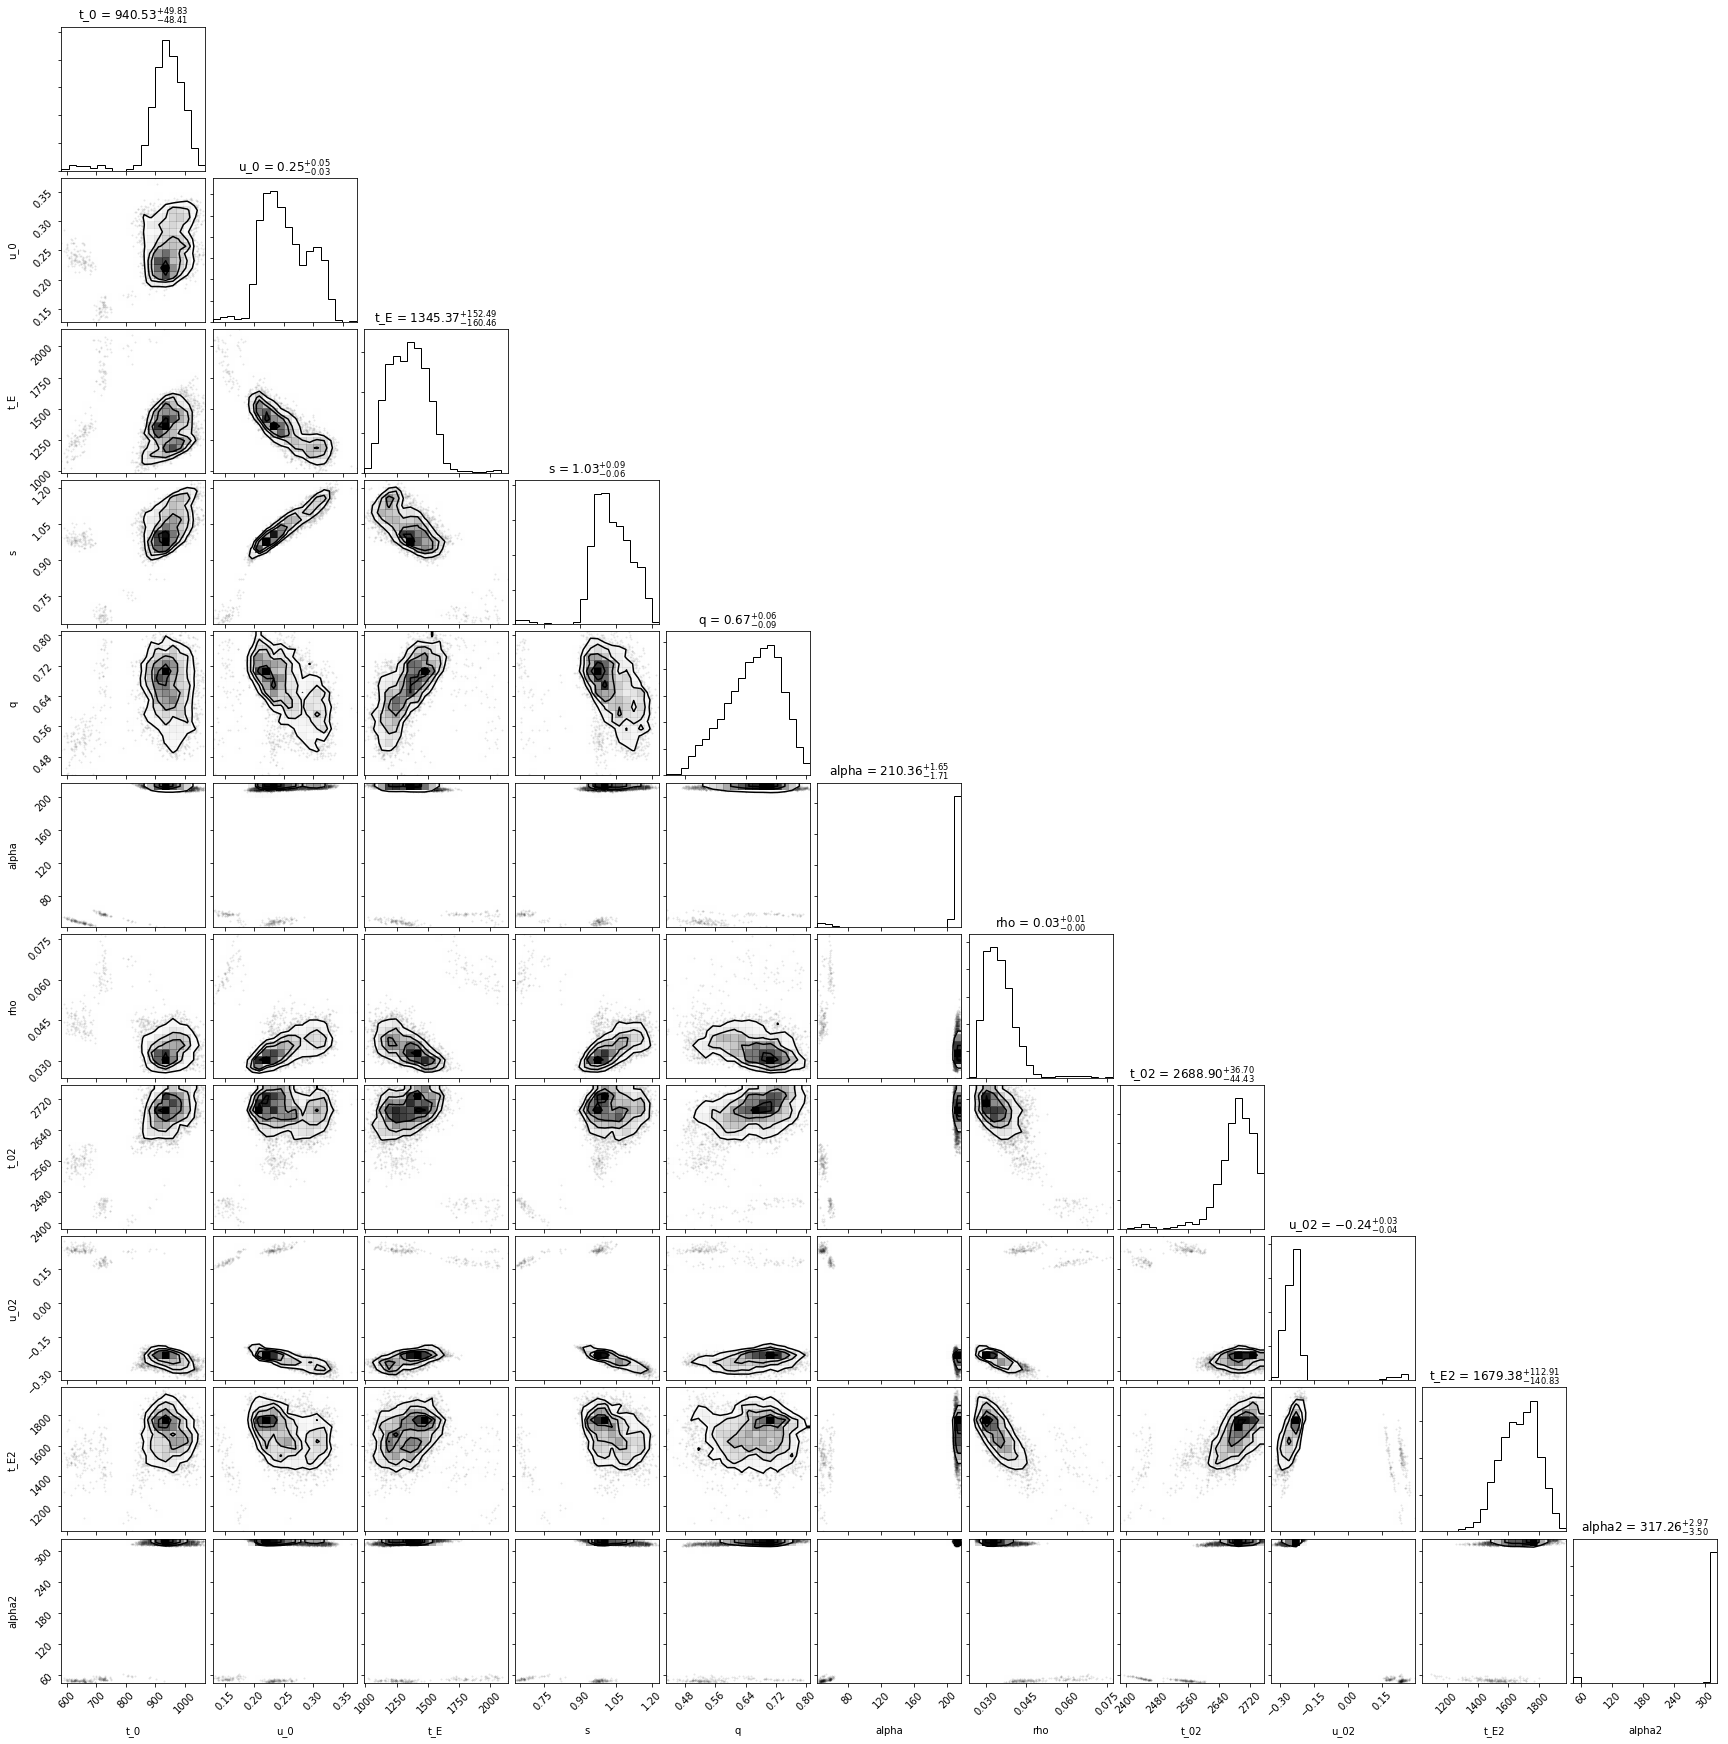

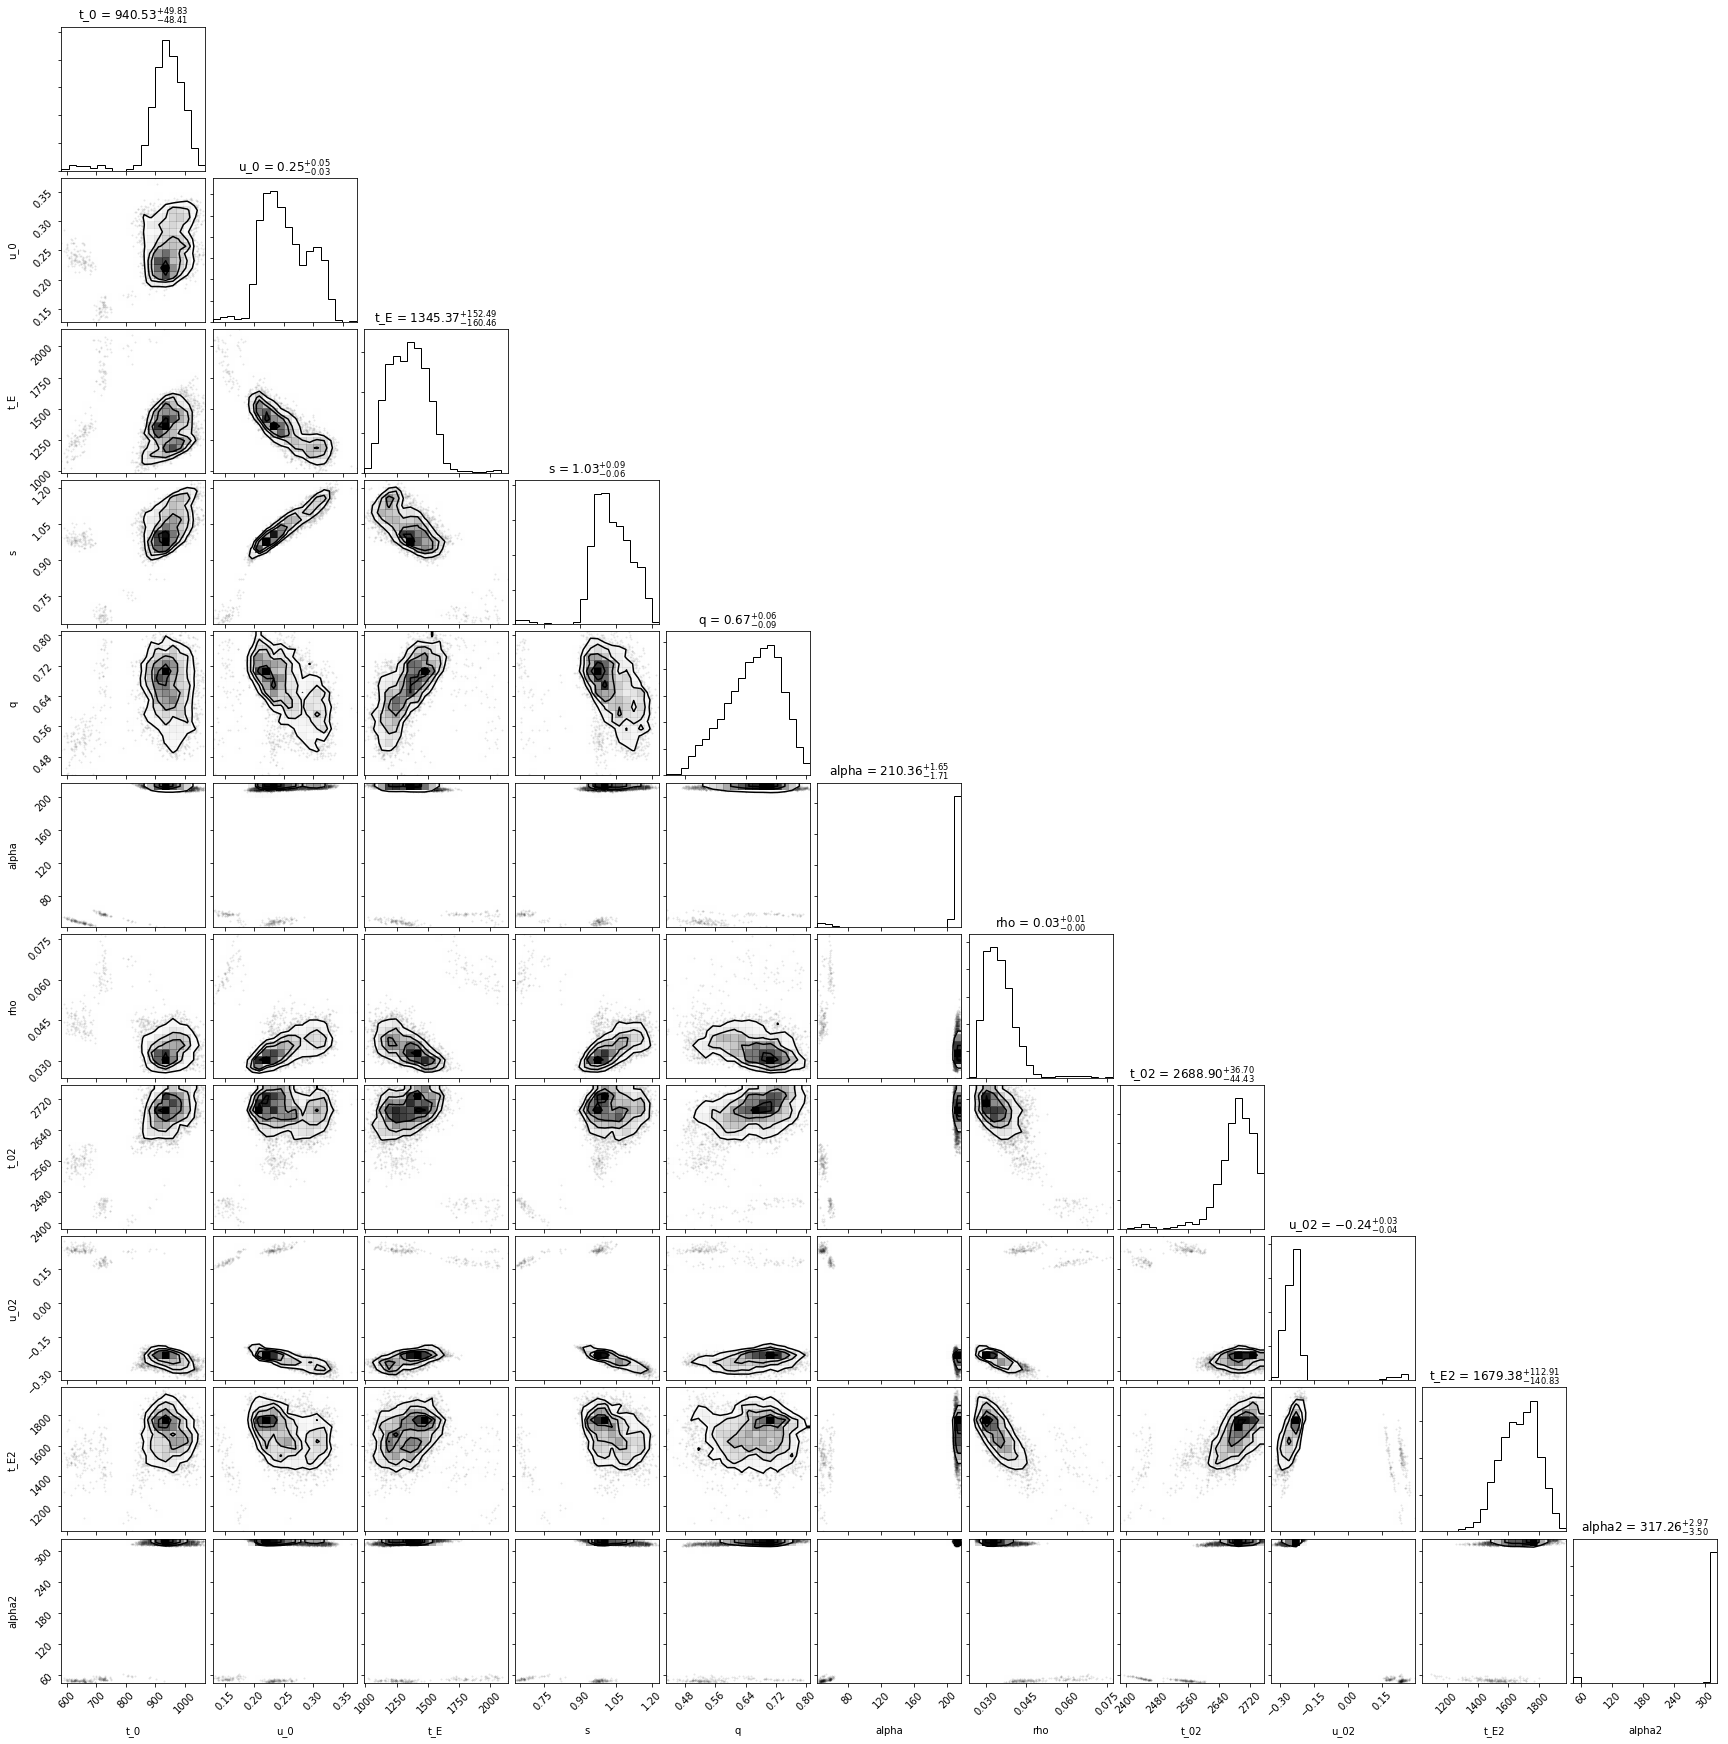

In [21]:
# if len(sys.argv) != 2:
#         sys.stderr.write("""SYNOPSIS: %s <output-root>
#         output-root:     Where the output of a MultiNest run has been written to.
#                           Example: chains/1-
# %s""" % (sys.argv[0], __doc__))
#         sys.exit(1)

# prefix = sys.argv[1]
# print('model "%s"' % prefix)
# if not os.path.exists(prefix + 'params.json'):
#         sys.stderr.write("""Expected the file %sparams.json with the parameter names.
# For example, for a three-dimensional problem:
# ["Redshift $z$", "my parameter 2", "A"]
# %s""" % (sys.argv[1], __doc__))
#         sys.exit(2)

s = a.get_stats()

#json.dump(s, open(prefix + 'stats.json', 'w'), indent=4)

print('  marginal likelihood:')
print('    ln Z = %.1f +- %.1f' % (s['global evidence'], s['global evidence error']))
print('  parameters:')
for p, m in zip(parameters, s['marginals']):
        lo, hi = m['1sigma']
        med = m['median']
        sigma = (hi - lo) / 2
        if sigma == 0:
                i = 3
        else:
                i = max(0, int(-np.floor(np.log10(sigma))) + 1)
        fmt = '%%.%df' % i
        fmts = '\t'.join(['    %-15s' + fmt + " +- " + fmt])
        print(fmts % (p, med, sigma))

print('creating marginal plot ...')
data = a.get_data()[:,2:]
weights = a.get_data()[:,0]

#mask = weights.cumsum() > 1e-5
mask = weights > 1e-4

corner.corner(data[mask,:], weights=weights[mask],
        labels=parameters, show_titles=True, title_fmt=".2f",)
# plt.savefig(prefix + 'corner.pdf')
# plt.savefig(prefix + 'corner.png')
# plt.close()

In [8]:
print( s, q, C)

1.2462841970201115 0.2922887232578552 0.6125448255826218


<Container object of 3 artists>

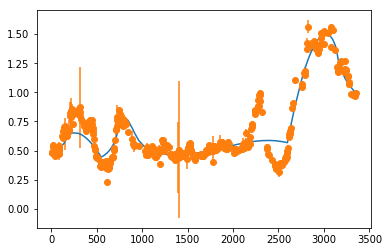

In [41]:
plt.plot(Day,flux_scale[0]*p_hat + flux_scale[1])
plt.errorbar(Day,Flux,yerr=Flux_err,fmt="o")